In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio import pairwise2

%matplotlib inline
# figure size in inches
# rcParams['figure.figsize'] = 12,9
#sns.set(rc={'figure.figsize':(12,9)})


# Enable Classic style in plots
plt.style.use('classic')


# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'png')
# plt.rcParams['savefig.dpi'] = 300

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 12, 9
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble']="\usepackage{subdepth}, \usepackage{type1cm}"

plt.rcParams['figure.facecolor'] = "white"

# Lempel-Ziv parser with inexact matching

## Notation

## Lempel-Ziv factorization

The parsing used is a variant of the traditional lempel-ziv parser, the method parses the text $S[i..j]$ into phrases (ie substrings) as follows, starting at $i \leftarrow 1$:

1. find the longest prefix $S[i..j]$ of $S[i..n]$ that occurs in $S$ starting before position $i$.
2. if $j \geq i$, that is, $S[i..j]$ is nonempty, then the next phrase is $S[i..j]$ and we set $i \leftarrow j + 1$
3. Otherwise, the next phrase is the explicit symbol $S[i]$, which has not appeared before, and we set $i \leftarrow i + 1$.
4. if $i \leq n$, continue forming phrases.

Also, the source $S[i'..j']$ of $S[i..j]$ must be completely contained in $S[1..i-1]$. That is, it must hold that $j' < i$, not just $i' < i$. In this approach, there's no overlap between the phrases and their sources. It comes with a price, the number of phrases obtained in this case will be called $z_{no}$ and:

1. not only $z_{no}(S) \geq z(S)$, because the greedy parsing (traditional) is optimal
2. $z_{no}$ can be $\Theta (log n)$ times larger than $z$, for example on the string $S = a^{n-1}\$$, where $z = 3$ with parsing **$a$|$a^{n-2}$** and $z_{no} = \Theta(log n)$ with parsing **$a$|$a$|$a^{2}$|$a^{4}$|$a^{8}$|...**

Actually we can experimentaly check this fact letting $S = AAAAAAAAAA\$$, ie, 10 repetitions of **A**.


Firstly, let's have a look at simpler examples found in the literature to check the correctness of the encoding produced by the LZ-mis, that is, the modified parsing of LZ parsers the allows mismatches.

Taking back to 93, there's a paper by Gusev et al that explored the lempel-ziv as a tool to analyse local structures of genomes. It differs from the traditional LZ76 parser by:

- In the traditional LZ76 parser, each phrase is either a generated symbol or a copied substring accompanied by the generation of an additional symbol, this excludes the possibility of coincidence of two phrases.

Let's consider the example 1 (Gusev et al, 93): Influenza virus type A, strain PR, segment of polymerase I, pos. 1411, N = 30, S = GTCGACAGGTTTTATCGAACCTGTAAGCTA.

In [176]:
13*5

65

In [177]:
# ! echo AAAAAAAAAA$ > multi_A.txt

with open('multi_A.txt', 'w') as infile:
    t = "${}${}".format(5*'AAAAACAAAAAAA',5*'AAAAATAAAAATA')
    infile.write(t[::-1])

In [178]:
t[23-9+1]

'A'

In [179]:
t[17+1:18+4]

'ACAA'

In [180]:
! cat multi_A.txt

ATAAAAATAAAAAATAAAAATAAAAAATAAAAATAAAAAATAAAAATAAAAAATAAAAATAAAAA$AAAAAAACAAAAAAAAAAAACAAAAAAAAAAAACAAAAAAAAAAAACAAAAAAAAAAAACAAAAA$

Then, we create the fm-index of the reverse text required by the parsing algorithm, but as the reverse of $A^{10}$ is equal $A^{10}$ we dont bother in reversing it. We construct the fm-index directly in $S$.

In [181]:
! ../../bin/sFM-index build multi_A.txt

Building succinct FM-index of file multi_A.txt
 Computing the BWT ... 
*** Building context automata ***

 Text length is 132

 scanning file to detect alphabet ... 
 0% done.
 5% done.
 10% done.
 15% done.
 20% done.
 25% done.
 30% done.
 35% done.
 40% done.
 45% done.
 50% done.
 55% done.
 60% done.
 65% done.
 70% done.
 75% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 Sorting alphabet ... done. Alphabet size: sigma = 4

 Alphabet (ASCII codes) = { 36 65 67 84 }

 Allowed memory overhead for the automata = 10%
 Detecting optimal k ... 
  Sampling text ... 
  0% done.

  Sampled text size = 132
  Extimated number of bits per k-mer: 4140
  Extimated number of bits per (k-1)-mer: 352
  Number of 1-mers : 5
 Done. Optimal k = 1

 detecting k-mers ... 
 0% done.
 5% done.
 10% done.
 15% done.
 20% done.
 25% done.
 30% done.
 35% done.
 40% done.
 45% done.
 50% done.
 55% done.
 60% done.
 65% done.
 70% done.
 75% done.
 80% done.
 85% done.
 90% done.
 95% done.
 do

Finally, we parse it with the following command:

In [217]:
! ../../bin/sFM-index lz multi_A.txt.sfm 2 multi_A.txt.sfm

Loading succinct FM-index from file multi_A.txt.sfm
Done.
Block size = 16
TEXT LENGTH = 132
###################################################
INITIALIZING ALGORITHM
###################################################


CHAR A int(CHAR) = 65 WITH P = 1, NEXT P = 3
CHAR A int(CHAR) = 65 WITH P = 3, NEXT P = 5
CHAR A int(CHAR) = 65 WITH P = 5, NEXT P = 7
CHAR A int(CHAR) = 65 WITH P = 7, NEXT P = 9
CHAR A int(CHAR) = 65 WITH P = 9, NEXT P = 11
CHAR C int(CHAR) = 67 WITH P = 11, NEXT P = 118
CHAR A int(CHAR) = 65 WITH P = 118, NEXT P = 103
CHAR A int(CHAR) = 65 WITH P = 103, NEXT P = 89
CHAR A int(CHAR) = 65 WITH P = 89, NEXT P = 75
CHAR A int(CHAR) = 65 WITH P = 75, NEXT P = 61
CHAR A int(CHAR) = 65 WITH P = 61, NEXT P = 47
CHAR A int(CHAR) = 65 WITH P = 47, NEXT P = 38
CHAR A int(CHAR) = 65 WITH P = 38, NEXT P = 33
CHAR A int(CHAR) = 65 WITH P = 33, NEXT P = 29
CHAR A int(CHAR) = 65 WITH P = 29, NEXT P = 25
CHAR A int(CHAR) = 65 WITH P = 25, NEXT P = 21
CHAR A int(CHAR) = 65 WITH P = 2

And exhibit the output:

In [218]:
dfok = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
dfok 

pos    p len type
0   65    0  65    N
1   66    $   -    -
2   77    0  12    M
3   83    0   6    M
4  130   71  47    N
5  131  NaN   -    -

In [106]:
t1 = 'acacgacttttacgtatctt'.upper()
t2 = 'acaccacttttacgttactt'.upper()
t3 = 'acacgacttttcggcgacgtatctt'.upper()
t4 = 'acacgacttttacgtt'.upper()
t5 = 'aacgtattttcacgactctt'.upper()
print('|T1|=', len(t1), '|T2|=', len(t2), '|T3|=', len(t3), '|T4|=', len(t4), '|T5|=', len(t5))

|T1|= 20 |T2|= 20 |T3|= 25 |T4|= 16 |T5|= 20


In [107]:
with open('single_A_ref.txt', 'w') as infile:
    t = "{}$".format(1*'acacgacttttacgtatctt'.upper())
    infile.write(t[::-1])
with open('single_A_sample.txt', 'w') as infile:
    t = '{}$'.format(1*t2)
    infile.write(t[::-1])

In [108]:
! ../../bin/sFM-index build single_A_ref.txt
! ../../bin/sFM-index build single_A_sample.txt

Building succinct FM-index of file single_A_ref.txt
 Computing the BWT ... 
*** Building context automata ***

 Text length is 21

 scanning file to detect alphabet ... 
 0% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 Sorting alphabet ... done. Alphabet size: sigma = 5

 Alphabet (ASCII codes) = { 36 65 67 71 84 }

 Allowed memory overhead for the automata = 10%
 Detecting optimal k ... 
  Sampling text ... 
  0% done.

  Sampled text size = 21
  Extimated number of bits per k-mer: 4944
  Extimated number of bits per (k-1)-mer: 384
  Number of 1-mers : 6
 Done. Optimal k = 1

 detecting k-mers ... 
 0% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 sorting k-mers ... done. 6 nonempty contexts of length k = 1 (including contexts containing terminator character)
 building automata edges ... 
 0% Done.
 50% Done.
 done.

Context automata completed.

*** Scanning input file to compute context frequencies ***

 0% done.
 80% done.
 85% done.
 90% done.
 95% done.


In [113]:
! ../../bin/sFM-index lz single_A_ref.txt.sfm 10 single_A_sample.txt.sfm

Loading succinct FM-index from file single_A_ref.txt.sfm
Done.
Block size = 4
TEXT LENGTH = 21
###################################################
INITIALIZING ALGORITHM
###################################################


###################################################
 FOR i = 0
Pop i = 0 c=  and c = int(c) =0 , actual base =  , max Ar=0 p =1 next c= , LF(p)=0  j=1, j new=0 aln len=0 iprime =0 L=1 U=2 num_mm = 0 n-(a.i+1) =20
Allow diff = 0
 INSIDE $ BASE DETECTION !!!  
J final=1
1	 	-	-
###################################################
 FOR i = 1
Pop i = 1 c=A and c =Aint(c) =65 , actual base = A, max Ar=20 p =0 next c=A, LF(p)=2  j=2, j new=1 aln len=0 iprime =0 L=2 U=7 num_mm = 0 n-(a.i+1) =19
Allow diff = 0
##  ALLOWING INNER MATCHES
###  IN c=C with iprime=1 and i=1, p=2
PROXIMO ALLOW DIFF = 0
## BEFORE Pushed MATCHED base C with 0 mis L=7 , U=11 , maxAr=19 max_Ar_ori=20 n-(i+1) = 19
## @@ TESTING FOR n-(i+1) = 19 BUT 0
##  Pushed MATCHED base C with 0 mis L=7 , U=11 , m

In [114]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos     p len type
0    1   NaN   -    -
1    5   0.0   4    N
2    8   1.0   3    N
3   16   7.0   8    N
4   19  10.0   3    N
5   20   7.0   2    N

In [184]:
def get_phrase_mismatched(df, original_text, start, end, print_mis=True):
    len_vec = df['len'].values[start:end]
    pointer_vec = df['p'].values[start:end]
    match_type = df['type'].values[start:end]
    text = ""
    for i in range(len(pointer_vec)):
        if (len_vec[i] == '-'):
            if (str(pointer_vec[i]) != "nan"):
                text += pointer_vec[i]
            if (str(pointer_vec[i]) == '$'):
                print("## PARSING NEXT TEXT\n")
        else:
            pos = int(pointer_vec[i])
            size = int(len_vec[i])
            copied_text = text[pos:pos+size]
            if (match_type[i] == 'M'):
                pos_original = len(text)
                if (print_mis):
                    alignments = pairwise2.align.globalxs(original_text[pos_original:pos_original+size],
                                                          copied_text, -10, -10,  one_alignment_only=True)
                    print(pairwise2.format_alignment(*alignments[0]))
                text += original_text[pos_original:pos_original+size]
            else:
                text += copied_text
    return(text)

In [185]:
get_phrase_mismatched(df, 5*'AAAAACAAAAAAA', 0, 10) == 5*'AAAAACAAAAAAA'

AAAAAA
|||||.
AAAAAC
  Score=5

AAAAAA
|||||.
AAAAAC
  Score=5



True

In [167]:
get_phrase_mismatched(df, 5*'AAAAACAAAAAAA'+'$'+5*'AAAAATAAAAATA', 0, 13, print_mis=False) == t[1:]

## PARSING NEXT TEXT



True

In [80]:
# ACGTAAAAAAAAA
#      *
#      C
#      *
# AAAAATAAAAATA
t[76+1-10:76+1] + t[87+1-11:87+1]

'AAAAATAAAAATAAAAAATAA'

In [79]:
t[4+1:4+1+10]

'AAAAAAAAAA'

In [57]:
t[67:67+10]

'AAAAATAAAA'

In [69]:
t[67]

'A'

In [101]:
#for x in (df['p'].values, df['len'].values)):
def get_original_text(df):
    len_vec = df['len'].values
    pointer_vec = df['p'].values
    text = ""
    for i in range(len(pointer_vec)):
        if (len_vec[i] == '-'):
            if (str(pointer_vec[i]) != "nan"):
                text += pointer_vec[i]
        else:
            pos = int(pointer_vec[i])
            size = int(len_vec[i])
            copied_text = text[pos:pos+size]
            text += copied_text
    return(text)

In [102]:
get_original_text(df)

'AAAAACAAAAACAAAAACCAAAAACAAAAACCAAAAACAAAAACCAAAAACAAAAACCAAAAACA$AAAAACAAAAACAAAAACCAAAAACAAAAACCAAAAACAAAAACCAAAAACAAAAACCAAAAACA'

In [40]:
! pwd

/Users/rodtheo/Bioinfo/PROJETOS/STUDIES/LZ/repos/BWTIL/tools/sFM-index


This confirms that we generated $z_{no} = 5$ and it shows the pattern expected by the parser. But why we're using this weaker lz-variant ? Because it eases direct pattern matching on the compressed string (Farach, M. and Thorup, M. 1998. String matching in Lempel-Ziv compressed strings. Algorithmica 20, 4, 388–404.)

In [437]:
! echo alabaralalabarda > tests/ala.txt

In [438]:
! cat tests/ala.txt | rev

adrabalalarabala


In [439]:
out = open('tests/ala_rev.txt', 'w')
out.write('adrabalalababala$')
out.close()

In [440]:
! cat tests/ala_rev.txt

adrabalalababala$

In [441]:
! ../../bin/sFM-index build tests/ala_rev.txt

Building succinct FM-index of file tests/ala_rev.txt
 Computing the BWT ... 
*** Building context automata ***

 Text length is 17

 scanning file to detect alphabet ... 
 0% done.
 5% done.
 35% done.
 70% done.
 done.

 Sorting alphabet ... done. Alphabet size: sigma = 6

 Alphabet (ASCII codes) = { 36 97 98 100 108 114 }

 Allowed memory overhead for the automata = 10%
 Detecting optimal k ... 
  Sampling text ... 
  0% done.

  Sampled text size = 17
  Extimated number of bits per k-mer: 5748
  Extimated number of bits per (k-1)-mer: 416
  Number of 1-mers : 7
 Done. Optimal k = 1

 detecting k-mers ... 
 0% done.
 5% done.
 35% done.
 70% done.
 done.

 sorting k-mers ... done. 7 nonempty contexts of length k = 1 (including contexts containing terminator character)
 building automata edges ... 
 0% Done.
 done.

Context automata completed.

*** Scanning input file to compute context frequencies ***

 0% done.
 5% done.
 35% done.
 70% done.
 Done.

 Expected context size (if unifo

In [448]:
! ../../bin/sFM-index lz tests/ala_rev.txt.sfm 10

Loading succinct FM-index from file tests/ala_rev.txt.sfm
Done.
Block size = 3
TEXT LENGTH = 17
###################################################
INITIALIZING ALGORITHM
###################################################


###################################################
 FOR i = 0
Pop i = 0 c=a and c =a , actual base = a, max Ar=15 p =1 next c=a, LF(p)=2  j=1, j new=0 aln len=0 iprime =0 L=2 U=10 num_mm = 0 n-(a.i+1) =16
DUPLICATED Pop i + allow_diff = 0 allow_diff = 0 c=a and c =a , actual base = a, max Ar=15 p =1 next c=a, LF(p)=2  j=1, j new=0 aln len=0 iprime =0 L=2 U=10 num_mm = 0
Allow diff = 0
 INSIDE THE MAX AR !!!
J final=1
1	a	-	-
###################################################
 FOR i = 1
Pop i = 1 c=l and c =l , actual base = l, max Ar=14 p =2 next c=l, LF(p)=14  j=2, j new=1 aln len=0 iprime =0 L=14 U=17 num_mm = 0 n-(a.i+1) =15
DUPLICATED Pop i + allow_diff = 1 allow_diff = 0 c=l and c =l , actual base = l, max Ar=14 p =2 next c=l, LF(p)=14  j=2, j new=1 aln len=

In [449]:
sorted(['#','$','A','C','G','T'])

['#', '$', 'A', 'C', 'G', 'T']

In [450]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos  p len type
0    1  a   -    -
1    2  l   -    -
2    3  0   1    N
3    4  b   -    -
4    6  2   2    N
5    9  0   3    N
6   13  1   4    N
7   14  r   -    -
8   15  d   -    -
9   16  a   -    -

In [416]:
get_original_text(df)

'alabaralalabarda$alababalalabarda'

In [418]:
T = 'alabaralalabarda'
T[0:0+4] + T[2:2+3] + T[7:7+4] + T[11:11+4]

'alababalalabard'

In [408]:
get_original_text(df) == 'alabaralalabarda'

False

In [456]:
! cat paper_lz_genomics_ex1_pointA19.txt

GTCGACAGGTTTTATCGAAACTGTAAGCTA


In [468]:
! ../../bin/sFM-index lz paper_lz_genomics_ex1_pointA19_rev.txt.sfm 10

Loading succinct FM-index from file paper_lz_genomics_ex1_pointA19_rev.txt.sfm
Done.
Block size = 6
TEXT LENGTH = 31
###################################################
INITIALIZING ALGORITHM
###################################################


###################################################
 FOR i = 0
Pop i = 0 c=G and c =G , actual base = G, max Ar=29 p =1 next c=G, LF(p)=16  j=1, j new=0 aln len=0 iprime =0 L=16 U=23 num_mm = 0 n-(a.i+1) =30
DUPLICATED Pop i + allow_diff = 0 allow_diff = 0 c=G and c =G , actual base = G, max Ar=29 p =1 next c=G, LF(p)=16  j=1, j new=0 aln len=0 iprime =0 L=16 U=23 num_mm = 0
Allow diff = 0
 INSIDE THE MAX AR !!!
J final=1
1	G	-	-
###################################################
 FOR i = 1
Pop i = 1 c=T and c =T , actual base = T, max Ar=28 p =16 next c=T, LF(p)=26  j=2, j new=1 aln len=0 iprime =0 L=23 U=32 num_mm = 0 n-(a.i+1) =29
DUPLICATED Pop i + allow_diff = 1 allow_diff = 0 c=T and c =T , actual base = T, max Ar=28 p =16 next c=T, LF(p

In [469]:
! cat out.txt

1	G	-	-
2	T	-	-
3	C	-	-
4	0	1	N
5	A	-	-
6	2	1	N
7	4	1	N
8	0	1	N
10	0	2	N
11	1	1	N
13	9	2	N
14	4	1	N
18	1	4	N
19	4	1	N
21	4	2	N
22	1	1	N
24	0	2	N
26	17	2	N
27	0	1	N
29	20	2	N
30	A	-	-


In [470]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos   p len type
0     1   G   -    -
1     2   T   -    -
2     3   C   -    -
3     4   0   1    N
4     5   A   -    -
5     6   2   1    N
6     7   4   1    N
7     8   0   1    N
8    10   0   2    N
9    11   1   1    N
10   13   9   2    N
11   14   4   1    N
12   18   1   4    N
13   19   4   1    N
14   21   4   2    N
15   22   1   1    N
16   24   0   2    N
17   26  17   2    N
18   27   0   1    N
19   29  20   2    N
20   30   A   -    -

In [471]:
get_original_text(df)

'GTCGACAGGTTTTATCGAAACTGTAAGCTA'

In [472]:
get_original_text(df) == 'GTCGACAGGTTTTATCGAAACTGTAAGCTA'

True

In [104]:
def get_phrase_mismatched(df, original_text, start, end, print_mis=True):
    len_vec = df['len'].values[start:end]
    pointer_vec = df['p'].values[start:end]
    match_type = df['type'].values[start:end]
    text = ""
    for i in range(len(pointer_vec)):
        if (len_vec[i] == '-'):
            if (str(pointer_vec[i]) != "nan"):
                text += pointer_vec[i]
        else:
            pos = int(pointer_vec[i])
            size = int(len_vec[i])
            copied_text = text[pos:pos+size]
            if (match_type[i] == 'M'):
                pos_original = len(text)
                if (print_mis):
                    alignments = pairwise2.align.globalxs(original_text[pos_original:pos_original+size],
                                                          copied_text, -10, -10,  one_alignment_only=True)
                    print(pairwise2.format_alignment(*alignments[0]))
                text += original_text[pos_original:pos_original+size]
            else:
                text += copied_text
    return(text)

In [486]:
! ../../bin/sFM-index lz paper_lz_genomics_ex1_pointA19_rev.txt.sfm 2

Loading succinct FM-index from file paper_lz_genomics_ex1_pointA19_rev.txt.sfm
Done.
Block size = 6
TEXT LENGTH = 31
###################################################
INITIALIZING ALGORITHM
###################################################


###################################################
 FOR i = 0
Pop i = 0 c=G and c =G , actual base = G, max Ar=29 p =1 next c=G, LF(p)=16  j=1, j new=0 aln len=0 iprime =0 L=16 U=23 num_mm = 0 n-(a.i+1) =30
DUPLICATED Pop i + allow_diff = 0 allow_diff = 0 c=G and c =G , actual base = G, max Ar=29 p =1 next c=G, LF(p)=16  j=1, j new=0 aln len=0 iprime =0 L=16 U=23 num_mm = 0
Allow diff = 0
 INSIDE THE MAX AR !!!
J final=1
1	G	-	-
###################################################
 FOR i = 1
Pop i = 1 c=T and c =T , actual base = T, max Ar=28 p =16 next c=T, LF(p)=26  j=2, j new=1 aln len=0 iprime =0 L=23 U=32 num_mm = 0 n-(a.i+1) =29
DUPLICATED Pop i + allow_diff = 1 allow_diff = 0 c=T and c =T , actual base = T, max Ar=28 p =16 next c=T, LF(p

In [487]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos   p len type
0     1   G   -    -
1     2   T   -    -
2     3   C   -    -
3     4   0   1    N
4     5   A   -    -
5     6   2   1    N
6     7   4   1    N
7     8   0   1    N
8    10   0   2    N
9    11   1   1    N
10   13   9   2    N
11   14   4   1    N
12   20   1   6    M
13   21   2   1    N
14   22   1   1    N
15   24   0   2    N
16   26  17   2    N
17   27   0   1    N
18   29  20   2    N
19   30   A   -    -

In [488]:
ori_text = 'GTCGACAGGTTTTATCGAAACTGTAAGCTA'

In [489]:
get_phrase_mismatched(df, ori_text) == ori_text

TCGAAA
||||.|
TCGACA
  Score=5



True

In [522]:
ori_text[::-1]

'ATCGAATGTCAAAGCTATTTTGGACAGCTG'

In [524]:
out = open('tests/paper_lz_genomics_ex1_pointA19_rev_double.txt', 'w')
out.write("ATCGAATGTCAAAGCTATTTGGGACAGCTG" + '$' + ori_text[::-1] + '#')
out.close()

In [525]:
#%%capture
! ../../bin/sFM-index build tests/paper_lz_genomics_ex1_pointA19_rev_double.txt

Building succinct FM-index of file tests/paper_lz_genomics_ex1_pointA19_rev_double.txt
 Computing the BWT ... 
*** Building context automata ***

 Text length is 62

 scanning file to detect alphabet ... 
 0% done.
 20% done.
 25% done.
 30% done.
 35% done.
 40% done.
 45% done.
 50% done.
 70% done.
 75% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 Sorting alphabet ... done. Alphabet size: sigma = 6

 Alphabet (ASCII codes) = { 35 36 65 67 71 84 }

 Allowed memory overhead for the automata = 10%
 Detecting optimal k ... 
  Sampling text ... 
  0% done.

  Sampled text size = 62
  Extimated number of bits per k-mer: 5748
  Extimated number of bits per (k-1)-mer: 416
  Number of 1-mers : 7
 Done. Optimal k = 1

 detecting k-mers ... 
 0% done.
 20% done.
 25% done.
 30% done.
 35% done.
 40% done.
 45% done.
 50% done.
 70% done.
 75% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 sorting k-mers ... done. 7 nonempty contexts of length k = 1 (including contexts

In [526]:
! ../../bin/sFM-index lz tests/paper_lz_genomics_ex1_pointA19_rev_double.txt.sfm 2

Loading succinct FM-index from file tests/paper_lz_genomics_ex1_pointA19_rev_double.txt.sfm
Done.
Block size = 10
TEXT LENGTH = 62
###################################################
INITIALIZING ALGORITHM
###################################################


###################################################
 FOR i = 0
Pop i = 0 c=G and c =G , actual base = G, max Ar=60 p =1 next c=G, LF(p)=31  j=1, j new=0 aln len=0 iprime =0 L=31 U=46 num_mm = 0 n-(a.i+1) =61
DUPLICATED Pop i + allow_diff = 0 allow_diff = 0 c=G and c =G , actual base = G, max Ar=60 p =1 next c=G, LF(p)=31  j=1, j new=0 aln len=0 iprime =0 L=31 U=46 num_mm = 0
Allow diff = 0
 INSIDE THE MAX AR !!!
J final=1
1	G	-	-
###################################################
 FOR i = 1
Pop i = 1 c=T and c =T , actual base = T, max Ar=59 p =31 next c=T, LF(p)=52  j=2, j new=1 aln len=0 iprime =0 L=46 U=63 num_mm = 0 n-(a.i+1) =60
DUPLICATED Pop i + allow_diff = 1 allow_diff = 0 c=T and c =T , actual base = T, max Ar=59 p =31 

In [527]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos    p len type
0     1    G   -    -
1     2    T   -    -
2     3    C   -    -
3     4    0   1    N
4     5    A   -    -
5     6    2   1    N
6     7    4   1    N
7     8    0   1    N
8    10    0   2    N
9    11    1   1    N
10   13    9   2    N
11   14    4   1    N
12   20    1   6    M
13   21    2   1    N
14   22    1   1    N
15   24    0   2    N
16   26   17   2    N
17   27    0   1    N
18   29   20   2    N
19   30    4   1    N
20   31    $   -    -
21   60    0  30    M
22   61  NaN   -    -

In [150]:
! cat paper_lz_genomics_ex1_pointA19.txt

GTCGACAGGTTTTATCGAAACTGTAAGCTA


In [528]:
get_phrase_mismatched(df, ori_text) == ori_text

TCGAAA
||||.|
TCGACA
  Score=5



IndexError: list index out of range

In [152]:
! wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/840/245/GCF_000840245.1_ViralProj14204/GCF_000840245.1_ViralProj14204_genomic.fna.gz

--2020-04-27 12:14:48--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/840/245/GCF_000840245.1_ViralProj14204/GCF_000840245.1_ViralProj14204_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.11, 2607:f220:41e:250::13
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15299 (15K) [application/x-gzip]
Saving to: ‘GCF_000840245.1_ViralProj14204_genomic.fna.gz’

GCF_000840245.1_Vir 100%[===================>]  14.94K  87.0KB/s    in 0.2s    

2020-04-27 12:14:51 (87.0 KB/s) - ‘GCF_000840245.1_ViralProj14204_genomic.fna.gz’ saved [15299/15299]



In [153]:
! zcat GCF_000840245.1_ViralProj14204_genomic.fna.gz > tests/lambda_phage.genome.fa

In [154]:
! rm GCF_000840245.1_ViralProj14204_genomic.fna.gz

In [19]:
for rec in SeqIO.parse('tests/lambda_phage.genome.fa', 'fasta'):
    lambda_ori = str(rec.seq)
    lambda_ori_rev = lambda_ori[::-1]

In [218]:
out = open('tests/lambda_phage_rev.txt', 'w')
out.write(str(lambda_ori_rev)+"$")
out.close()

In [220]:
set(list(lambda_ori_rev))

{'A', 'C', 'G', 'T'}

In [221]:
! time ../../bin/sFM-index build tests/lambda_phage_rev.txt

Building succinct FM-index of file tests/lambda_phage_rev.txt
 Computing the BWT ... 
*** Building context automata ***

 Text length is 48503

 scanning file to detect alphabet ... 
 0% done.
 5% done.
 10% done.
 15% done.
 20% done.
 25% done.
 30% done.
 35% done.
 40% done.
 45% done.
 50% done.
 55% done.
 60% done.
 65% done.
 70% done.
 75% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 Sorting alphabet ... done. Alphabet size: sigma = 5

 Alphabet (ASCII codes) = { 36 65 67 71 84 }

 Allowed memory overhead for the automata = 10%
 Detecting optimal k ... 
  Sampling text ... 
  0% done.
  10% done.
  20% done.
  30% done.
  35% done.
  45% done.
  55% done.
  65% done.
  70% done.
  80% done.
  90% done.

  Sampled text size = 2000
  Extimated number of bits per k-mer: 5072
  Extimated number of bits per (k-1)-mer: 384
  Number of 1-mers : 6
 Done. Optimal k = 1

 detecting k-mers ... 
 0% done.
 5% done.
 10% done.
 15% done.
 20% done.
 25% done.
 30% done.
 35% 

In [138]:
%time ! ../../bin/sFM-index lz tests/lambda_phage_rev.txt.sfm 5 &> tests/tmp.txt

CPU times: user 66.5 ms, sys: 31.5 ms, total: 97.9 ms
Wall time: 4.7 s


In [139]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos      p len type
0         1      G   -    -
1         2      0   1    N
2         3      0   1    N
3         4      C   -    -
4         7      1   3    N
5         8      0   1    N
6         9      A   -    -
7        10      3   1    N
8        11      3   1    N
9        12      T   -    -
10       14      3   2    N
11       17      3   3    N
12       18      0   1    N
13       19     11   1    N
14       20     11   1    N
15       22     18   2    N
16       25     12   3    N
17       26     11   1    N
18       27      8   1    N
19       30     18   3    N
20       32     26   2    N
21       34      7   2    N
22       35      8   1    N
23       37     33   2    N
24       42     18   5    N
25       45      3   3    N
26       49     27   4    N
27       50      8   1    N
28       54      1   4    N
29       60     38   6    N
...     ...    ...  ..  ...
6179  48257  33165  10    M
6180  48265   5738   8    M
6181  48274   8240   9    M
6182  48284    274  10    M
6183  48293  46548   9    M
6184  48301  10566   8    M
6185  48310   7394   9    M
6186  48322  15255  12    M
6187  48331  41792   9    M
6188  48339  23368   8    M
6189  48347   4204   8    M
6190  48356  23651   9    M
6191  48366  41014  10    M
6192  48376   6470  10    M
6193  48385  24985   9    M
6194  48393   8717   8    M
6195  48402     69   9    M
6196  48410   1987   8    M
6197  48418   1798   8    M
6198  48427   8621   9    M
6199  48435   1346   8    M
6200  48444  31910   9    M
6201  48450  27652   6    N
6202  48458  41080   8    M
6203  48466   4601   8    M
6204  48476  14826  10    M
6205  48486  11002  10    M
6206  48494   4774   8    M
6207  48501  12183   8    N
6208  48502    NaN   -    -

[6209 rows x 4 columns]

In [189]:
df.loc[df['p'] == "18446744073709551615", "p"] = "0"

In [190]:
df

pos      p len type
0         1      0   1    N
1         2      C   -    -
2         3      C   -    -
3         4      T   -    -
4         5      0   1    N
5         6      A   -    -
6         7      T   -    -
7         9      1   2    N
8        10      7   1    N
9        12      0   2    N
10       13     10   1    N
11       14      7   1    N
12       16      1   2    N
13       17      2   1    N
14       18      7   1    N
15       20     16   2    N
16       22      6   2    N
17       24      1   2    N
18       25      7   1    N
19       26     10   1    N
20       27      7   1    N
21       29     17   2    N
22       32      1   3    N
23       34      8   2    N
24       37     22   3    N
25       39     10   2    N
26       40      7   1    N
27       42      0   2    N
28       45     29   3    N
29       47      9   2    N
...     ...    ...  ..  ...
3744  25900    699   9    M
3745  25909    274   9    M
3746  25919    525  10    M
3747  25927   8001   8    M
3748  25935   6582   8    M
3749  25942   1106   7    M
3750  25950   4130   8    M
3751  25958   8684   8    M
3752  25965   6887   7    M
3753  25972    100   7    M
3754  25980   7178   8    M
3755  25987   4109   7    M
3756  25994    630   7    M
3757  26001    412   7    M
3758  26008   3416   7    M
3759  26015   7662   7    M
3760  26024   1543   9    M
3761  26031   5238   7    M
3762  26038   4375   7    M
3763  26049   9246  11    M
3764  26056   4938   7    M
3765  26065   3227   9    M
3766  26073  22774   8    M
3767  26081  23602   8    M
3768  26089  23698   8    M
3769  26097  10269   8    M
3770  26102   3080   5    N
3771  26110   3950   8    M
3772  26117   2165   7    M
3773  26124    119   7    M

[3774 rows x 4 columns]

In [226]:
get_phrase_mismatched(df, str(lambda_ori), print_mis=False) == lambda_ori

True

In [250]:
#%%capture
ks = []
number_of_factors_total = []
number_of_mis = []
for k in range(4,13):
    print("===== {}".format(str(k)))
    %time ! ../../bin/sFM-index lz tests/lambda_phage_rev.txt.sfm {k} &> tests/tmp.txt
    
    df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])

    assert(get_phrase_mismatched(df, str(lambda_ori), print_mis=False) == lambda_ori)
    
    ks.append(k)
    number_of_factors_total.append(df.shape[0])
    number_of_mis.append(sum(df['type'] == 'M'))

===== 4
CPU times: user 95.3 ms, sys: 39.8 ms, total: 135 ms
Wall time: 6.54 s
===== 5
CPU times: user 71.2 ms, sys: 31.5 ms, total: 103 ms
Wall time: 4.87 s
===== 6
CPU times: user 62.7 ms, sys: 25.9 ms, total: 88.6 ms
Wall time: 4.28 s
===== 7
CPU times: user 58.9 ms, sys: 24.7 ms, total: 83.6 ms
Wall time: 4.03 s
===== 8
CPU times: user 59.4 ms, sys: 27.1 ms, total: 86.4 ms
Wall time: 4.01 s
===== 9
CPU times: user 58.4 ms, sys: 27.7 ms, total: 86.1 ms
Wall time: 3.95 s
===== 10
CPU times: user 59 ms, sys: 25.5 ms, total: 84.5 ms
Wall time: 3.99 s
===== 11
CPU times: user 60 ms, sys: 26.2 ms, total: 86.2 ms
Wall time: 4 s
===== 12
CPU times: user 59.1 ms, sys: 28 ms, total: 87.1 ms
Wall time: 3.96 s


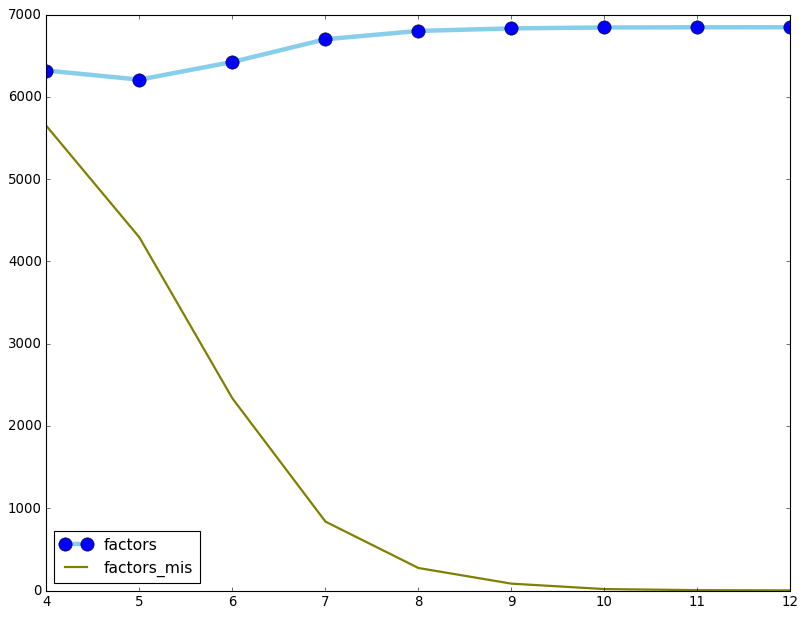

In [271]:
#plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
#plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
df_to_plot = pd.DataFrame({'factors': number_of_factors_total, 'factors_mis': number_of_mis, 'k': ks})
plt.plot('k', 'factors', data=df_to_plot, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot('k', 'factors_mis', data=df_to_plot, marker='', color='olive', linewidth=2)
plt.legend(loc=0)

plt.show()

In [304]:
c = "alabaralalabarda"
c = c[::-1]

In [307]:
c

'adrabalalarabala$'

In [305]:
cs = []
c = c + '$'
for i in range(0,len(c)):
    cs.append((i+1, c[i:]))

In [306]:
sorted(cs, key=lambda x: x[1])

[(17, '$'),
 (16, 'a$'),
 (12, 'abala$'),
 (4, 'abalalarabala$'),
 (1, 'adrabalalarabala$'),
 (14, 'ala$'),
 (6, 'alalarabala$'),
 (8, 'alarabala$'),
 (10, 'arabala$'),
 (13, 'bala$'),
 (5, 'balalarabala$'),
 (2, 'drabalalarabala$'),
 (15, 'la$'),
 (7, 'lalarabala$'),
 (9, 'larabala$'),
 (11, 'rabala$'),
 (3, 'rabalalarabala$')]

In [309]:
bwt_matrix = []
for i in range(0, len(c)):
    bwt_matrix.append(c[i:]+c[:i])

In [314]:
print('\n'.join(sorted(bwt_matrix)))

$adrabalalarabala
a$adrabalalarabal
abala$adrabalalar
abalalarabala$adr
adrabalalarabala$
ala$adrabalalarab
alalarabala$adrab
alarabala$adrabal
arabala$adrabalal
bala$adrabalalara
balalarabala$adra
drabalalarabala$a
la$adrabalalaraba
lalarabala$adraba
larabala$adrabala
rabala$adrabalala
rabalalarabala$ad


## Segmental duplication

In [6]:
! wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/840/245/GCF_000840245.1_ViralProj14204/GCF_000840245.1_ViralProj14204_genomic.gff.gz

--2020-04-29 11:38:40--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/840/245/GCF_000840245.1_ViralProj14204/GCF_000840245.1_ViralProj14204_genomic.gff.gz
Resolving ftp.ncbi.nlm.nih.gov... 130.14.250.7, 2607:f220:41e:250::12
Connecting to ftp.ncbi.nlm.nih.gov|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8295 (8.1K) [application/x-gzip]
Saving to: ‘GCF_000840245.1_ViralProj14204_genomic.gff.gz’

GCF_000840245.1_Vir 100%[===================>]   8.10K  --.-KB/s    in 0.002s  

2020-04-29 11:38:41 (4.20 MB/s) - ‘GCF_000840245.1_ViralProj14204_genomic.gff.gz’ saved [8295/8295]



In [7]:
! zcat GCF_000840245.1_ViralProj14204_genomic.gff.gz > tests/lambda_phage.gff

In [8]:
! rm GCF_000840245.1_ViralProj14204_genomic.gff.gz

```bash
(bioAnalysisEnv)
rodtheo @ ~/Bioinfo/PROGRAMAS/Simulome
 [84] python /Users/rodtheo/Bioinfo/PROGRAMAS/Simulome/simulome.py --genome=/Users/rodtheo/Bioinfo/PROJETOS/STUDIES/LZ/repos/BWTIL/tools/sFM-index/tests/lambda_phage.genome.fa --anno=/Users/rodtheo/Bioinfo/PROJETOS/STUDIES/LZ/repos/BWTIL/tools/sFM-index/tests/lambda_phage.gff --output=lambda_phage_sd --snp=TRUE --snp_window=100 --num_snp=50 --whole_genome=TRUE --seed=123456
	Writing annotation file: lambda_phage_sd/lambda_phage_sd_simulated.gff
	Writing FASTA file: lambda_phage_sd/lambda_phage_sd_simulated.fasta
	Writing annotation file: lambda_phage_sd/lambda_phage_sd_mutated_simulation.gff
	Writing FASTA file: lambda_phage_sd/lambda_phage_sd_mutated_simulation.fasta
	Writing mutation log file: lambda_phage_sd/lambda_phage_sd_mutations.log
Process Complete.
```

In [12]:
! mv /Users/rodtheo/Bioinfo/PROGRAMAS/Simulome/lambda_phage_sd/ tests/

In [37]:
! cat tests/lambda_phage_sd/lambda_phage_sd_mutations.log

START	END	TYPE	BEFORE	AFTER
336	337	SNP	G	T
2723	2724	SNP	G	C
4673	4674	SNP	C	T
5890	5891	SNP	G	C
6577	6578	SNP	T	A
7252	7253	SNP	A	C
7717	7718	SNP	G	C
8093	8094	SNP	T	C
9300	9301	SNP	C	T
9985	9986	SNP	G	T
11080	11081	SNP	G	C
13979	13980	SNP	T	C
14446	14447	SNP	G	T
15821	15822	SNP	T	G
19108	19109	SNP	G	C
19675	19676	SNP	G	T
21084	21085	SNP	A	G
23201	23202	SNP	C	A
25017	25018	SNP	G	A
35374	35375	SNP	C	T
36338	36339	SNP	T	C
38443	38444	SNP	A	G
38760	38761	SNP	G	A
40350	40351	SNP	G	A
41003	41004	SNP	A	C
42120	42121	SNP	T	A
42299	42300	SNP	A	T
43102	43103	SNP	G	A
43887	43888	SNP	G	T
44591	44592	SNP	T	G
45216	45217	SNP	C	A
46078	46079	SNP	C	A
46618	46619	SNP	C	A
47145	47146	SNP	A	T


In [115]:
for reca in SeqIO.parse('tests/lambda_phage_sd/lambda_phage_sd_simulated.fasta', 'fasta'):
    lambda_seq = str(reca.seq)
for recb in SeqIO.parse('tests/lambda_phage_sd/lambda_phage_sd_mutated_simulation.fasta', 'fasta'):
    lambda_simu = str(recb.seq)

In [116]:
lambda_simu

'GGGCGGCGACCTCGCGGGTTTTCGCTATTTATGAAAATTTTCCGGTTTAAGGCGTTTCCGTTCTTCTTCGTCATAACTTAATGTTTTTATTTAAAATACCCTCTGAAAAGAAAGGAAACGACAGGTGCTGAAAGCGAGGCTTTTTGGCCTCTGTCGTTTCCTTTCTCTGTTTTTGTCCGTGGAATGAACAATGGAAGTCAACAAAAAGCAGCTGGCTGACATTTTCGGTGCGAGTATCCGTACCATTCAGAACTGGCAGGAACAGGGAATGCCCGTTCTGCGAGGCGGTGGCAAGGGTAATGAGGTGCTTTATGACTCTGCCGCCGTCATAAAATGTTATGCCGAAAGGGATGCTGAAATTGAGAACGAAAAGCTGCGCCGGGAGGTTGAAGAACTGCGGCAGGCCAGCGAGGCAGATCTCCAGCCAGGAACTATTGAGTACGAACGCCATCGACTTACGCGTGCGCAGGCCGACGCACAGGAACTGAAGAATGCCAGAGACTCCGCTGAAGTGGTGGAAACCGCATTCTGTACTTTCGTGCTGTCGCGGATCGCAGGTGAAATTGCCAGTATTCTCGACGGGCTCCCCCTGTCGGTGCAGCGGCGTTTTCCGGAACTGGAAAACCGACATGTTGATTTCCTGAAACGGGATATCATCAAAGCCATGAACAAAGCAGCCGCGCTGGATGAACTGATACCGGGGTTGCTGAGTGAATATATCGAACAGTCAGGTTAACAGGCTGCGGCATTTTGTCCGCGCCGGGCTTCGCTCACTGTTCAGGCCGGAGCCACAGACCGCCGTTGAATGGGCGGATGCTAATTACTATCTCCCGAAAGAATCCGCATACCAGGAAGGGCGCTGGGAAACACTGCCCTTTCAGCGGGCCATCATGAATGCGATGGGCAGCGACTACATCCGTGAGGTGAATGTGGTGAAGTCTGCCCGTGTCGGTTATTCCAAAATGCTGCTGGGTGTTTATGCCTACTTTATAGAGCATA

In [117]:
lambda_simu == lambda_seq

False

In [118]:
lambda_seq[336:337]

'G'

In [119]:
lambda_simu[336:337]

'T'

Lets use the convetional LZ to parse two genomic sequences, one after another.

In [189]:
t = '$' + lambda_seq + '$' + lambda_simu

In [190]:
concat_lambda_rev = t[::-1]

In [147]:
with open('tests/lambda_phage_sd/lambda_phage_concat_rev.txt', 'w') as outf:
    outf.write(concat_lambda_rev)

In [168]:
! time ../../bin/sFM-index build tests/lambda_phage_sd/lambda_phage_concat_rev.txt

Building succinct FM-index of file tests/lambda_phage_sd/lambda_phage_concat_rev.txt
 Computing the BWT ... 
*** Building context automata ***

 Text length is 97008

 scanning file to detect alphabet ... 
 0% done.
 5% done.
 10% done.
 15% done.
 20% done.
 25% done.
 30% done.
 35% done.
 40% done.
 45% done.
 50% done.
 55% done.
 60% done.
 65% done.
 70% done.
 75% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 Sorting alphabet ... done. Alphabet size: sigma = 5

 Alphabet (ASCII codes) = { 36 65 67 71 84 }

 Allowed memory overhead for the automata = 10%
 Detecting optimal k ... 
  Sampling text ... 
  0% done.
  5% done.
  10% done.
  15% done.
  20% done.
  25% done.
  30% done.
  35% done.
  40% done.
  45% done.
  50% done.
  55% done.
  60% done.
  65% done.
  70% done.
  75% done.
  80% done.
  85% done.
  90% done.

  Sampled text size = 5000
  Extimated number of bits per k-mer: 5072
  Extimated number of bits per (k-1)-mer: 384
  Number of 1-mers : 6
 Done. 

In [186]:
%time ! ../../bin/sFM-index lz tests/lambda_phage_sd/lambda_phage_concat_rev.txt.sfm 10 &> tests/lambda_phage_sd/tmp.txt

CPU times: user 149 ms, sys: 56.4 ms, total: 205 ms
Wall time: 9.96 s


In [193]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos      p    len type
0         1      G      -    -
1         2      0      1    N
2         3      0      1    N
3         4      C      -    -
4         7      1      3    N
5         8      0      1    N
6         9      A      -    -
7        10      3      1    N
8        11      3      1    N
9        12      T      -    -
10       14      3      2    N
11       17      3      3    N
12       18      0      1    N
13       19     11      1    N
14       20     11      1    N
15       22     18      2    N
16       25     12      3    N
17       26     11      1    N
18       27      8      1    N
19       30     18      3    N
20       32     26      2    N
21       34      7      2    N
22       35      8      1    N
23       37     33      2    N
24       42     18      5    N
25       45      3      3    N
26       49     27      4    N
27       50      8      1    N
28       54      1      4    N
29       60     38      6    N
...     ...    ...    ...  ...
6820  48339  23367      8    N
6821  48347  36468      8    N
6822  48355  26365      8    N
6823  48363  37939      8    N
6824  48370  29213      7    N
6825  48377   5461      7    N
6826  48385  33734      8    N
6827  48393   8716      8    N
6828  48401     68      8    N
6829  48410  22838      9    N
6830  48419   5400      9    N
6831  48427  43242      8    N
6832  48435   1345      8    N
6833  48444  31909      9    N
6834  48451  27651      7    N
6835  48458  41080      7    N
6836  48467  25421      9    N
6837  48476  14826      9    N
6838  48486  11001     10    N
6839  48493   6190      7    N
6840  48501  39829      8    N
6841  48503      3      2    N
6842  48504      $      -    -
6843  59584      0  11081    M
6844  86946  11081  27363    M
6845  95120  38444   8175    M
6846  97004  46619   1884    M
6847  97005    NaN      -    -
6848  97006      $      -    -
6849  97007      G      -    -

[6850 rows x 4 columns]

In [44]:
np.sum([int(x) for x in df['len'][:6842].values if x != '-']) + np.sum(df['len'][:6842].values == '-')

48503

In [171]:
11081+27363+8175+1884

48503

In [196]:
get_phrase_mismatched(df, lambda_seq, 0, 6842, print_mis=True) == lambda_seq

CGAACAGTCAGGA
||||||||||||.
CGAACAGTCAGGT
  Score=12

GGGGATGTATGGCCAT
|||||||||||||.||
GGGGATGTATGGCGAT
  Score=15

TTATCCGGTGATGAG
||||||||||||||.
TTATCCGGTGATGAT
  Score=14

TGGAGAAGCATGCC
||||||||||||.|
TGGAGAAGCATGAC
  Score=13

CAGCACCACAGAC
||||||||||||.
CAGCACCACAGAG
  Score=12

GCGGCTTTTCCGC
||||||||||||.
GCGGCTTTTCCGG
  Score=12

AAAAACAGCGGCGG
||||||||||||.|
AAAAACAGCGGCAG
  Score=13

GTGCTCATGCCCAT
|||||||||||||.
GTGCTCATGCCCAC
  Score=13

TATGGAGTAATCTTTT
||||||||||||.|||
TATGGAGTAATCGTTT
  Score=15

TTTCTTTTGTGCA
||||||||||||.
TTTCTTTTGTGCG
  Score=12

ATTTCTTTTGTGG
||||||||||||.
ATTTCTTTTGTGC
  Score=12

CCGCTTCACGCAG
||||||||||||.
CCGCTTCACGCAA
  Score=12

TACAAAACCAATTTCA
||||||||||||||.|
TACAAAACCAATTTTA
  Score=15

ATTGCCGTCGTTC
||||||||||||.
ATTGCCGTCGTTG
  Score=12

TCAGCTATTGCCA
||||||||||||.
TCAGCTATTGCCT
  Score=12

ATAACCCGCAGAA
||||||||||||.
ATAACCCGCAGAC
  Score=12

TCAATTGTTATCT
||||||||||||.
TCAATTGTTATCA
  Score=12

TGTTGCATGGTGCC
|||||||||||||.
TGTTGCATGG

True

In [197]:
get_phrase_mismatched(df, t[1:], 0, 6847, print_mis=False) == t[1:]

## PARSING NEXT TEXT



True

Now lets use the **RLZ** algorithm to parse the sequences:

In [120]:
tref = lambda_seq
tsamp   = lambda_simu

In [121]:
with open('tests/lambda_phage_sd/lambda_ref.txt', 'w') as infile:
    t = "{}$".format(tref)
    infile.write(t[::-1])
with open('tests/lambda_phage_sd/lambda_sample.txt', 'w') as infile:
    t = '{}$'.format(tsamp)
    infile.write(t[::-1])

In [126]:
! time ../../bin/sFM-index build tests/lambda_phage_sd/lambda_ref.txt
! time ../../bin/sFM-index build tests/lambda_phage_sd/lambda_sample.txt

Building succinct FM-index of file tests/lambda_phage_sd/lambda_ref.txt
 Computing the BWT ... 
*** Building context automata ***

 Text length is 48504

 scanning file to detect alphabet ... 
 0% done.
 5% done.
 10% done.
 15% done.
 20% done.
 25% done.
 30% done.
 35% done.
 40% done.
 45% done.
 50% done.
 55% done.
 60% done.
 65% done.
 70% done.
 75% done.
 80% done.
 85% done.
 90% done.
 95% done.
 done.

 Sorting alphabet ... done. Alphabet size: sigma = 5

 Alphabet (ASCII codes) = { 36 65 67 71 84 }

 Allowed memory overhead for the automata = 10%
 Detecting optimal k ... 
  Sampling text ... 
  0% done.
  10% done.
  20% done.
  30% done.
  35% done.
  45% done.
  55% done.
  65% done.
  70% done.
  80% done.

  Sampled text size = 5000
  Extimated number of bits per k-mer: 5072
  Extimated number of bits per (k-1)-mer: 384
  Number of 1-mers : 5
 Done. Optimal k = 1

 detecting k-mers ... 
 0% done.
 5% done.
 10% done.
 15% done.
 20% done.
 25% done.
 30% done.
 35% do

In [174]:
# %%capture
%time ! ../../bin/sFM-index lz tests/lambda_phage_sd/lambda_ref.txt.sfm 10 tests/lambda_phage_sd/lambda_sample.txt.sfm

Loading succinct FM-index from file tests/lambda_phage_sd/lambda_ref.txt.sfm
Done.
Block size = 3031
TEXT LENGTH = 48504
1	 	-	-
PROXIMO ALLOW DIFF = 0
PROXIMO ALLOW DIFF = 1
PROXIMO ALLOW DIFF = 2
PROXIMO ALLOW DIFF = 3
PROXIMO ALLOW DIFF = 4
PROXIMO ALLOW DIFF = 5
PROXIMO ALLOW DIFF = 6
PROXIMO ALLOW DIFF = 7
PROXIMO ALLOW DIFF = 8
PROXIMO ALLOW DIFF = 9
PROXIMO ALLOW DIFF = 10
PROXIMO ALLOW DIFF = 11
AAAAQUI 48502
PROXIMO ALLOW DIFF = 12
AAAAQUI 48502
PROXIMO ALLOW DIFF = 13
AAAAQUI 48502
PROXIMO ALLOW DIFF = 14
AAAAQUI 48502
PROXIMO ALLOW DIFF = 15
AAAAQUI 48502
PROXIMO ALLOW DIFF = 16
AAAAQUI 48502
PROXIMO ALLOW DIFF = 17
AAAAQUI 48502
PROXIMO ALLOW DIFF = 18
AAAAQUI 48502
PROXIMO ALLOW DIFF = 19
AAAAQUI 48502
PROXIMO ALLOW DIFF = 20
AAAAQUI 48502
PROXIMO ALLOW DIFF = 21
AAAAQUI 48502
PROXIMO ALLOW DIFF = 22
AAAAQUI 48502
PROXIMO ALLOW DIFF = 23
AAAAQUI 48502
PROXIMO ALLOW DIFF = 24
AAAAQUI 48502
PROXIMO ALLOW DIFF = 25
AAAAQUI 48502
PROXIMO ALLOW DIFF = 26
AAAAQUI 48502
PROXIMO A

PROXIMO ALLOW DIFF = 2366
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2367
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2368
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2369
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2370
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2371
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2372
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2373
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2374
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2375
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2376
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2377
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2378
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2379
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2380
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2381
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2382
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2383
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2384
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2385
AAAAQUI 48502
PROXIMO ALLOW DIFF = 2386
AAAAQUI 48502
2724	1	2724	M
PROXIMO ALLOW DIFF = 0
PROXIMO ALLOW DIFF = 1
PROXIMO ALLOW DIFF = 2
PROXIMO ALLOW DIFF = 3
PROXIMO ALLOW DIFF = 4
PROXIMO ALLOW DIFF = 5
PROXIMO 

AAAAQUI 40412
PROXIMO ALLOW DIFF = 298
AAAAQUI 40412
PROXIMO ALLOW DIFF = 299
AAAAQUI 40412
PROXIMO ALLOW DIFF = 300
AAAAQUI 40412
PROXIMO ALLOW DIFF = 301
AAAAQUI 40412
PROXIMO ALLOW DIFF = 302
AAAAQUI 40412
PROXIMO ALLOW DIFF = 303
AAAAQUI 40412
PROXIMO ALLOW DIFF = 304
AAAAQUI 40412
PROXIMO ALLOW DIFF = 305
AAAAQUI 40412
PROXIMO ALLOW DIFF = 306
AAAAQUI 40412
PROXIMO ALLOW DIFF = 307
AAAAQUI 40412
PROXIMO ALLOW DIFF = 308
AAAAQUI 40412
PROXIMO ALLOW DIFF = 309
AAAAQUI 40412
PROXIMO ALLOW DIFF = 310
AAAAQUI 40412
PROXIMO ALLOW DIFF = 311
AAAAQUI 40412
PROXIMO ALLOW DIFF = 312
AAAAQUI 40412
PROXIMO ALLOW DIFF = 313
AAAAQUI 40412
PROXIMO ALLOW DIFF = 314
AAAAQUI 40412
PROXIMO ALLOW DIFF = 315
AAAAQUI 40412
PROXIMO ALLOW DIFF = 316
AAAAQUI 40412
PROXIMO ALLOW DIFF = 317
AAAAQUI 40412
PROXIMO ALLOW DIFF = 318
AAAAQUI 40412
PROXIMO ALLOW DIFF = 319
AAAAQUI 40412
PROXIMO ALLOW DIFF = 320
AAAAQUI 40412
PROXIMO ALLOW DIFF = 321
AAAAQUI 40412
PROXIMO ALLOW DIFF = 322
AAAAQUI 40412
PROXIMO ALL

PROXIMO ALLOW DIFF = 1281
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1282
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1283
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1284
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1285
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1286
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1287
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1288
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1289
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1290
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1291
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1292
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1293
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1294
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1295
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1296
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1297
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1298
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1299
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1300
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1301
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1302
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1303
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1304
AAAAQUI 34528
PROXIMO ALLOW DIFF = 1305
AAAAQUI 34528


PROXIMO ALLOW DIFF = 1346
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1347
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1348
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1349
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1350
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1351
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1352
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1353
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1354
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1355
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1356
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1357
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1358
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1359
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1360
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1361
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1362
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1363
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1364
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1365
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1366
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1367
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1368
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1369
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1370
AAAAQUI 28834


PROXIMO ALLOW DIFF = 3936
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3937
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3938
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3939
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3940
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3941
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3942
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3943
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3944
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3945
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3946
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3947
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3948
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3949
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3950
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3951
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3952
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3953
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3954
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3955
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3956
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3957
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3958
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3959
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3960
AAAAQUI 25309


PROXIMO ALLOW DIFF = 10020
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10021
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10022
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10023
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10024
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10025
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10026
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10027
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10028
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10029
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10030
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10031
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10032
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10033
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10034
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10035
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10036
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10037
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10038
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10039
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10040
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10041
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10042
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10043
AAAAQUI 25309
PROXIMO ALLOW DI

AAAAQUI 8163
PROXIMO ALLOW DIFF = 758
AAAAQUI 8163
PROXIMO ALLOW DIFF = 759
AAAAQUI 8163
PROXIMO ALLOW DIFF = 760
AAAAQUI 8163
PROXIMO ALLOW DIFF = 761
AAAAQUI 8163
PROXIMO ALLOW DIFF = 762
AAAAQUI 8163
PROXIMO ALLOW DIFF = 763
AAAAQUI 8163
PROXIMO ALLOW DIFF = 764
AAAAQUI 8163
PROXIMO ALLOW DIFF = 765
AAAAQUI 8163
PROXIMO ALLOW DIFF = 766
AAAAQUI 8163
PROXIMO ALLOW DIFF = 767
AAAAQUI 8163
PROXIMO ALLOW DIFF = 768
AAAAQUI 8163
PROXIMO ALLOW DIFF = 769
AAAAQUI 8163
PROXIMO ALLOW DIFF = 770
AAAAQUI 8163
PROXIMO ALLOW DIFF = 771
AAAAQUI 8163
PROXIMO ALLOW DIFF = 772
AAAAQUI 8163
PROXIMO ALLOW DIFF = 773
AAAAQUI 8163
PROXIMO ALLOW DIFF = 774
AAAAQUI 8163
PROXIMO ALLOW DIFF = 775
AAAAQUI 8163
PROXIMO ALLOW DIFF = 776
AAAAQUI 8163
PROXIMO ALLOW DIFF = 777
AAAAQUI 8163
PROXIMO ALLOW DIFF = 778
AAAAQUI 8163
PROXIMO ALLOW DIFF = 779
AAAAQUI 8163
PROXIMO ALLOW DIFF = 780
AAAAQUI 8163
PROXIMO ALLOW DIFF = 781
AAAAQUI 8163
PROXIMO ALLOW DIFF = 782
AAAAQUI 8163
PROXIMO ALLOW DIFF = 783
AAAAQUI 8163

PROXIMO ALLOW DIFF = 255
AAAAQUI 1373
PROXIMO ALLOW DIFF = 256
AAAAQUI 1373
PROXIMO ALLOW DIFF = 257
AAAAQUI 1373
PROXIMO ALLOW DIFF = 258
AAAAQUI 1373
PROXIMO ALLOW DIFF = 259
AAAAQUI 1373
PROXIMO ALLOW DIFF = 260
AAAAQUI 1373
PROXIMO ALLOW DIFF = 261
AAAAQUI 1373
PROXIMO ALLOW DIFF = 262
AAAAQUI 1373
PROXIMO ALLOW DIFF = 263
AAAAQUI 1373
PROXIMO ALLOW DIFF = 264
AAAAQUI 1373
PROXIMO ALLOW DIFF = 265
AAAAQUI 1373
PROXIMO ALLOW DIFF = 266
AAAAQUI 1373
PROXIMO ALLOW DIFF = 267
AAAAQUI 1373
PROXIMO ALLOW DIFF = 268
AAAAQUI 1373
PROXIMO ALLOW DIFF = 269
AAAAQUI 1373
PROXIMO ALLOW DIFF = 270
AAAAQUI 1373
PROXIMO ALLOW DIFF = 271
AAAAQUI 1373
PROXIMO ALLOW DIFF = 272
AAAAQUI 1373
PROXIMO ALLOW DIFF = 273
AAAAQUI 1373
PROXIMO ALLOW DIFF = 274
AAAAQUI 1373
PROXIMO ALLOW DIFF = 275
AAAAQUI 1373
PROXIMO ALLOW DIFF = 276
AAAAQUI 1373
PROXIMO ALLOW DIFF = 277
AAAAQUI 1373
PROXIMO ALLOW DIFF = 278
AAAAQUI 1373
PROXIMO ALLOW DIFF = 279
AAAAQUI 1373
PROXIMO ALLOW DIFF = 280
AAAAQUI 1373
PROXIMO ALLO

CPU times: user 223 ms, sys: 87.4 ms, total: 310 ms
Wall time: 557 ms


In [175]:
! valgrind --tool=massif ../../bin/sFM-index lz tests/lambda_phage_sd/lambda_ref.txt.sfm 10 tests/lambda_phage_sd/lambda_sample.txt.sfm

==15011== Massif, a heap profiler
==15011== Copyright (C) 2003-2017, and GNU GPL'd, by Nicholas Nethercote
==15011== Using Valgrind-3.14.0 and LibVEX; rerun with -h for copyright info
==15011== Command: ../../bin/sFM-index lz tests/lambda_phage_sd/lambda_ref.txt.sfm 10 tests/lambda_phage_sd/lambda_sample.txt.sfm
==15011== 
--15011-- run: /usr/bin/dsymutil "../../bin/sFM-index"
Loading succinct FM-index from file tests/lambda_phage_sd/lambda_ref.txt.sfm
Done.
Block size = 3031
TEXT LENGTH = 48504
1	 	-	-
PROXIMO ALLOW DIFF = 0
PROXIMO ALLOW DIFF = 1
PROXIMO ALLOW DIFF = 2
PROXIMO ALLOW DIFF = 3
PROXIMO ALLOW DIFF = 4
PROXIMO ALLOW DIFF = 5
PROXIMO ALLOW DIFF = 6
PROXIMO ALLOW DIFF = 7
PROXIMO ALLOW DIFF = 8
PROXIMO ALLOW DIFF = 9
PROXIMO ALLOW DIFF = 10
PROXIMO ALLOW DIFF = 11
AAAAQUI 48502
PROXIMO ALLOW DIFF = 12
AAAAQUI 48502
PROXIMO ALLOW DIFF = 13
AAAAQUI 48502
PROXIMO ALLOW DIFF = 14
AAAAQUI 48502
PROXIMO ALLOW DIFF = 15
AAAAQUI 48502
PROXIMO ALLOW DIFF = 16
AAAAQUI 48502
PROXIMO A

PROXIMO ALLOW DIFF = 427
AAAAQUI 48502
PROXIMO ALLOW DIFF = 428
AAAAQUI 48502
PROXIMO ALLOW DIFF = 429
AAAAQUI 48502
PROXIMO ALLOW DIFF = 430
AAAAQUI 48502
PROXIMO ALLOW DIFF = 431
AAAAQUI 48502
PROXIMO ALLOW DIFF = 432
AAAAQUI 48502
PROXIMO ALLOW DIFF = 433
AAAAQUI 48502
PROXIMO ALLOW DIFF = 434
AAAAQUI 48502
PROXIMO ALLOW DIFF = 435
AAAAQUI 48502
PROXIMO ALLOW DIFF = 436
AAAAQUI 48502
PROXIMO ALLOW DIFF = 437
AAAAQUI 48502
PROXIMO ALLOW DIFF = 438
AAAAQUI 48502
PROXIMO ALLOW DIFF = 439
AAAAQUI 48502
PROXIMO ALLOW DIFF = 440
AAAAQUI 48502
PROXIMO ALLOW DIFF = 441
AAAAQUI 48502
PROXIMO ALLOW DIFF = 442
AAAAQUI 48502
PROXIMO ALLOW DIFF = 443
AAAAQUI 48502
PROXIMO ALLOW DIFF = 444
AAAAQUI 48502
PROXIMO ALLOW DIFF = 445
AAAAQUI 48502
PROXIMO ALLOW DIFF = 446
AAAAQUI 48502
PROXIMO ALLOW DIFF = 447
AAAAQUI 48502
PROXIMO ALLOW DIFF = 448
AAAAQUI 48502
PROXIMO ALLOW DIFF = 449
AAAAQUI 48502
PROXIMO ALLOW DIFF = 450
AAAAQUI 48502
PROXIMO ALLOW DIFF = 451

PROXIMO ALLOW DIFF = 452
AAAAQUI 48502

PROXIMO ALLOW DIFF = 1747
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1748
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1749
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1750
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1751
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1752
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1753
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1754
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1755
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1756
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1757
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1758
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1759
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1760
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1761
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1762
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1763
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1764
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1765
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1766
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1767
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1768
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1769
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1770
AAAAQUI 48502
PROXIMO ALLOW DIFF = 1771
AAAAQUI 48502


PROXIMO ALLOW DIFF = 573
AAAAQUI 45779
PROXIMO ALLOW DIFF = 574
AAAAQUI 45779
PROXIMO ALLOW DIFF = 575
AAAAQUI 45779
PROXIMO ALLOW DIFF = 576
AAAAQUI 45779
PROXIMO ALLOW DIFF = 577
AAAAQUI 45779
PROXIMO ALLOW DIFF = 578
AAAAQUI 45779
PROXIMO ALLOW DIFF = 579
AAAAQUI 45779
PROXIMO ALLOW DIFF = 580
AAAAQUI 45779
PROXIMO ALLOW DIFF = 581
AAAAQUI 45779
PROXIMO ALLOW DIFF = 582
AAAAQUI 45779
PROXIMO ALLOW DIFF = 583
AAAAQUI 45779
PROXIMO ALLOW DIFF = 584
AAAAQUI 45779
PROXIMO ALLOW DIFF = 585
AAAAQUI 45779
PROXIMO ALLOW DIFF = 586
AAAAQUI 45779
PROXIMO ALLOW DIFF = 587
AAAAQUI 45779
PROXIMO ALLOW DIFF = 588
AAAAQUI 45779
PROXIMO ALLOW DIFF = 589
AAAAQUI 45779
PROXIMO ALLOW DIFF = 590
AAAAQUI 45779
PROXIMO ALLOW DIFF = 591
AAAAQUI 45779
PROXIMO ALLOW DIFF = 592
AAAAQUI 45779
PROXIMO ALLOW DIFF = 593
AAAAQUI 45779
PROXIMO ALLOW DIFF = 594
AAAAQUI 45779
PROXIMO ALLOW DIFF = 595
AAAAQUI 45779
PROXIMO ALLOW DIFF = 596
AAAAQUI 45779
PROXIMO ALLOW DIFF = 597

PROXIMO ALLOW DIFF = 598
AAAAQUI 45779

PROXIMO ALLOW DIFF = 1944
AAAAQUI 45779
PROXIMO ALLOW DIFF = 1945
AAAAQUI 45779
PROXIMO ALLOW DIFF = 1946
AAAAQUI 45779
PROXIMO ALLOW DIFF = 1947
AAAAQUI 45779
PROXIMO ALLOW DIFF = 1948
AAAAQUI 45779
PROXIMO ALLOW DIFF = 0
PROXIMO ALLOW DIFF = 1
PROXIMO ALLOW DIFF = 2
PROXIMO ALLOW DIFF = 3
PROXIMO ALLOW DIFF = 4
PROXIMO ALLOW DIFF = 5
PROXIMO ALLOW DIFF = 6
PROXIMO ALLOW DIFF = 7
PROXIMO ALLOW DIFF = 8
PROXIMO ALLOW DIFF = 9
PROXIMO ALLOW DIFF = 10
PROXIMO ALLOW DIFF = 11
AAAAQUI 45779
PROXIMO ALLOW DIFF = 12
AAAAQUI 45779
PROXIMO ALLOW DIFF = 13
AAAAQUI 45779
PROXIMO ALLOW DIFF = 14
AAAAQUI 45779
PROXIMO ALLOW DIFF = 15
AAAAQUI 45779
PROXIMO ALLOW DIFF = 16
AAAAQUI 45779
PROXIMO ALLOW DIFF = 17
AAAAQUI 45779
PROXIMO ALLOW DIFF = 18
AAAAQUI 45779
PROXIMO ALLOW DIFF = 19
AAAAQUI 45779
PROXIMO ALLOW DIFF = 20
AAAAQUI 45779
PROXIMO ALLOW DIFF = 21
AAAAQUI 45779
PROXIMO ALLOW DIFF = 22
AAAAQUI 45779
PROXIMO ALLOW DIFF = 23
AAAAQUI 45779
PROXIMO ALLOW DIFF = 24
AAAAQUI 45779
PROXIMO ALLOW 

AAAAQUI 42613
PROXIMO ALLOW DIFF = 26
AAAAQUI 42613
PROXIMO ALLOW DIFF = 27
AAAAQUI 42613
PROXIMO ALLOW DIFF = 28
AAAAQUI 42613
PROXIMO ALLOW DIFF = 29
AAAAQUI 42613
PROXIMO ALLOW DIFF = 30
AAAAQUI 42613
PROXIMO ALLOW DIFF = 31
AAAAQUI 42613
PROXIMO ALLOW DIFF = 32
AAAAQUI 42613
PROXIMO ALLOW DIFF = 33
AAAAQUI 42613
PROXIMO ALLOW DIFF = 34
AAAAQUI 42613
PROXIMO ALLOW DIFF = 35
AAAAQUI 42613
PROXIMO ALLOW DIFF = 36
AAAAQUI 42613
PROXIMO ALLOW DIFF = 37
AAAAQUI 42613
PROXIMO ALLOW DIFF = 38
AAAAQUI 42613
PROXIMO ALLOW DIFF = 39
AAAAQUI 42613
PROXIMO ALLOW DIFF = 40
AAAAQUI 42613
PROXIMO ALLOW DIFF = 41
AAAAQUI 42613
PROXIMO ALLOW DIFF = 42
AAAAQUI 42613
PROXIMO ALLOW DIFF = 43
AAAAQUI 42613
PROXIMO ALLOW DIFF = 44
AAAAQUI 42613
PROXIMO ALLOW DIFF = 45
AAAAQUI 42613
PROXIMO ALLOW DIFF = 46
AAAAQUI 42613
PROXIMO ALLOW DIFF = 47
AAAAQUI 42613
PROXIMO ALLOW DIFF = 48
AAAAQUI 42613
PROXIMO ALLOW DIFF = 49
AAAAQUI 42613
PROXIMO ALLOW DIFF = 50
AAAAQUI 42613
PROXIMO ALLOW DIFF = 51
AAAAQUI 4261

PROXIMO ALLOW DIFF = 566
AAAAQUI 42613
PROXIMO ALLOW DIFF = 567
AAAAQUI 42613
PROXIMO ALLOW DIFF = 568
AAAAQUI 42613
PROXIMO ALLOW DIFF = 569
AAAAQUI 42613
PROXIMO ALLOW DIFF = 570
AAAAQUI 42613
PROXIMO ALLOW DIFF = 571
AAAAQUI 42613
PROXIMO ALLOW DIFF = 572
AAAAQUI 42613
PROXIMO ALLOW DIFF = 573
AAAAQUI 42613
PROXIMO ALLOW DIFF = 574
AAAAQUI 42613
PROXIMO ALLOW DIFF = 575
AAAAQUI 42613
PROXIMO ALLOW DIFF = 576
AAAAQUI 42613
PROXIMO ALLOW DIFF = 577
AAAAQUI 42613
PROXIMO ALLOW DIFF = 578
AAAAQUI 42613
PROXIMO ALLOW DIFF = 579
AAAAQUI 42613
PROXIMO ALLOW DIFF = 580
AAAAQUI 42613
PROXIMO ALLOW DIFF = 581
AAAAQUI 42613
PROXIMO ALLOW DIFF = 582
AAAAQUI 42613
PROXIMO ALLOW DIFF = 583
AAAAQUI 42613
PROXIMO ALLOW DIFF = 584
AAAAQUI 42613
PROXIMO ALLOW DIFF = 585
AAAAQUI 42613
PROXIMO ALLOW DIFF = 586
AAAAQUI 42613
PROXIMO ALLOW DIFF = 587
AAAAQUI 42613
PROXIMO ALLOW DIFF = 588
AAAAQUI 42613
PROXIMO ALLOW DIFF = 589
AAAAQUI 42613
PROXIMO ALLOW DIFF = 590

PROXIMO ALLOW DIFF = 591
AAAAQUI 42613

AAAAQUI 40412
PROXIMO ALLOW DIFF = 354
AAAAQUI 40412
PROXIMO ALLOW DIFF = 355
AAAAQUI 40412
PROXIMO ALLOW DIFF = 356
AAAAQUI 40412
PROXIMO ALLOW DIFF = 357
AAAAQUI 40412
PROXIMO ALLOW DIFF = 358
AAAAQUI 40412
PROXIMO ALLOW DIFF = 359
AAAAQUI 40412
PROXIMO ALLOW DIFF = 360
AAAAQUI 40412
PROXIMO ALLOW DIFF = 361
AAAAQUI 40412
PROXIMO ALLOW DIFF = 362
AAAAQUI 40412
PROXIMO ALLOW DIFF = 363
AAAAQUI 40412
PROXIMO ALLOW DIFF = 364
AAAAQUI 40412
PROXIMO ALLOW DIFF = 365
AAAAQUI 40412
PROXIMO ALLOW DIFF = 366
AAAAQUI 40412
PROXIMO ALLOW DIFF = 367
AAAAQUI 40412
PROXIMO ALLOW DIFF = 368
AAAAQUI 40412
PROXIMO ALLOW DIFF = 369
AAAAQUI 40412
PROXIMO ALLOW DIFF = 370
AAAAQUI 40412
PROXIMO ALLOW DIFF = 371
AAAAQUI 40412
PROXIMO ALLOW DIFF = 372
AAAAQUI 40412
PROXIMO ALLOW DIFF = 373
AAAAQUI 40412
PROXIMO ALLOW DIFF = 374
AAAAQUI 40412
PROXIMO ALLOW DIFF = 375
AAAAQUI 40412
PROXIMO ALLOW DIFF = 376
AAAAQUI 40412
PROXIMO ALLOW DIFF = 377
AAAAQUI 40412

AAAAQUI 40412
PROXIMO ALLOW DIFF = 379
AAAAQUI 40

PROXIMO ALLOW DIFF = 379
AAAAQUI 40412
PROXIMO ALLOW DIFF = 380
AAAAQUI 40412
PROXIMO ALLOW DIFF = 381
AAAAQUI 40412
PROXIMO ALLOW DIFF = 382
AAAAQUI 40412
PROXIMO ALLOW DIFF = 383
AAAAQUI 40412
PROXIMO ALLOW DIFF = 384
AAAAQUI 40412
PROXIMO ALLOW DIFF = 385
AAAAQUI 40412
PROXIMO ALLOW DIFF = 386
AAAAQUI 40412
PROXIMO ALLOW DIFF = 387
AAAAQUI 40412
PROXIMO ALLOW DIFF = 388
AAAAQUI 40412
PROXIMO ALLOW DIFF = 389
AAAAQUI 40412
PROXIMO ALLOW DIFF = 390
AAAAQUI 40412
PROXIMO ALLOW DIFF = 391
AAAAQUI 40412
PROXIMO ALLOW DIFF = 392
AAAAQUI 40412
PROXIMO ALLOW DIFF = 393
AAAAQUI 40412
PROXIMO ALLOW DIFF = 394
AAAAQUI 40412
PROXIMO ALLOW DIFF = 395
AAAAQUI 40412
PROXIMO ALLOW DIFF = 396
AAAAQUI 40412
PROXIMO ALLOW DIFF = 397
AAAAQUI 40412
PROXIMO ALLOW DIFF = 398
AAAAQUI 40412
PROXIMO ALLOW DIFF = 399
AAAAQUI 40412
PROXIMO ALLOW DIFF = 400
AAAAQUI 40412
PROXIMO ALLOW DIFF = 401
AAAAQUI 40412
PROXIMO ALLOW DIFF = 402
AAAAQUI 40412
PROXIMO ALLOW DIFF = 403

PROXIMO ALLOW DIFF = 404
AAAAQUI 40412

PROXIMO ALLOW DIFF = 951
AAAAQUI 38521
PROXIMO ALLOW DIFF = 952
AAAAQUI 38521
PROXIMO ALLOW DIFF = 953
AAAAQUI 38521
PROXIMO ALLOW DIFF = 954
AAAAQUI 38521
PROXIMO ALLOW DIFF = 955
AAAAQUI 38521
PROXIMO ALLOW DIFF = 956
AAAAQUI 38521
PROXIMO ALLOW DIFF = 957
AAAAQUI 38521
PROXIMO ALLOW DIFF = 958
AAAAQUI 38521
PROXIMO ALLOW DIFF = 959
AAAAQUI 38521
PROXIMO ALLOW DIFF = 960
AAAAQUI 38521
PROXIMO ALLOW DIFF = 961
AAAAQUI 38521
PROXIMO ALLOW DIFF = 962
AAAAQUI 38521
PROXIMO ALLOW DIFF = 963
AAAAQUI 38521
PROXIMO ALLOW DIFF = 964
AAAAQUI 38521
PROXIMO ALLOW DIFF = 965
AAAAQUI 38521
PROXIMO ALLOW DIFF = 966
AAAAQUI 38521
PROXIMO ALLOW DIFF = 967
AAAAQUI 38521
PROXIMO ALLOW DIFF = 968
AAAAQUI 38521
PROXIMO ALLOW DIFF = 969
AAAAQUI 38521
PROXIMO ALLOW DIFF = 970
AAAAQUI 38521
PROXIMO ALLOW DIFF = 971
AAAAQUI 38521
PROXIMO ALLOW DIFF = 972
AAAAQUI 38521
PROXIMO ALLOW DIFF = 973
AAAAQUI 38521
PROXIMO ALLOW DIFF = 974
AAAAQUI 38521
PROXIMO ALLOW DIFF = 975

PROXIMO ALLOW DIFF = 976
AAAAQUI 38521

AAAAQUI 38521
PROXIMO ALLOW DIFF = 1141
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1142
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1143
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1144
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1145
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1146
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1147
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1148
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1149
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1150
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1151
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1152
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1153
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1154
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1155
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1156
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1157
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1158
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1159
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1160
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1161
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1162
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1163
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1164
AAAAQUI 38521
PROXIMO ALLOW DIFF = 1165


AAAAQUI 38521
PROXIMO ALLOW DIFF = 2436
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2437
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2438
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2439
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2440
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2441
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2442
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2443
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2444
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2445
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2446
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2447
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2448
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2449
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2450
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2451
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2452
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2453
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2454
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2455
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2456
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2457
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2458
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2459
AAAAQUI 38521
PROXIMO ALLOW DIFF = 2460


PROXIMO ALLOW DIFF = 379
AAAAQUI 34528
PROXIMO ALLOW DIFF = 380
AAAAQUI 34528
PROXIMO ALLOW DIFF = 381
AAAAQUI 34528
PROXIMO ALLOW DIFF = 382
AAAAQUI 34528
PROXIMO ALLOW DIFF = 383
AAAAQUI 34528
PROXIMO ALLOW DIFF = 384
AAAAQUI 34528
PROXIMO ALLOW DIFF = 385
AAAAQUI 34528
PROXIMO ALLOW DIFF = 386
AAAAQUI 34528
PROXIMO ALLOW DIFF = 387
AAAAQUI 34528
PROXIMO ALLOW DIFF = 388
AAAAQUI 34528
PROXIMO ALLOW DIFF = 389
AAAAQUI 34528
PROXIMO ALLOW DIFF = 390
AAAAQUI 34528
PROXIMO ALLOW DIFF = 391
AAAAQUI 34528
PROXIMO ALLOW DIFF = 392
AAAAQUI 34528
PROXIMO ALLOW DIFF = 393
AAAAQUI 34528
PROXIMO ALLOW DIFF = 394
AAAAQUI 34528
PROXIMO ALLOW DIFF = 395
AAAAQUI 34528
PROXIMO ALLOW DIFF = 396
AAAAQUI 34528
PROXIMO ALLOW DIFF = 397
AAAAQUI 34528
PROXIMO ALLOW DIFF = 398
AAAAQUI 34528
PROXIMO ALLOW DIFF = 399
AAAAQUI 34528
PROXIMO ALLOW DIFF = 400
AAAAQUI 34528
PROXIMO ALLOW DIFF = 401
AAAAQUI 34528
PROXIMO ALLOW DIFF = 402
AAAAQUI 34528
PROXIMO ALLOW DIFF = 403

PROXIMO ALLOW DIFF = 404
AAAAQUI 34528

PROXIMO ALLOW DIFF = 349
AAAAQUI 32687
PROXIMO ALLOW DIFF = 350
AAAAQUI 32687
PROXIMO ALLOW DIFF = 351
AAAAQUI 32687
PROXIMO ALLOW DIFF = 352
AAAAQUI 32687
PROXIMO ALLOW DIFF = 353
AAAAQUI 32687
PROXIMO ALLOW DIFF = 354
AAAAQUI 32687
PROXIMO ALLOW DIFF = 355
AAAAQUI 32687
PROXIMO ALLOW DIFF = 356
AAAAQUI 32687
PROXIMO ALLOW DIFF = 357
AAAAQUI 32687
PROXIMO ALLOW DIFF = 358
AAAAQUI 32687
PROXIMO ALLOW DIFF = 359
AAAAQUI 32687
PROXIMO ALLOW DIFF = 360
AAAAQUI 32687
PROXIMO ALLOW DIFF = 361
AAAAQUI 32687
PROXIMO ALLOW DIFF = 362
AAAAQUI 32687
PROXIMO ALLOW DIFF = 363
AAAAQUI 32687
PROXIMO ALLOW DIFF = 364
AAAAQUI 32687
PROXIMO ALLOW DIFF = 365
AAAAQUI 32687
PROXIMO ALLOW DIFF = 366
AAAAQUI 32687
PROXIMO ALLOW DIFF = 367
AAAAQUI 32687
PROXIMO ALLOW DIFF = 368
AAAAQUI 32687
PROXIMO ALLOW DIFF = 369
AAAAQUI 32687
PROXIMO ALLOW DIFF = 370
AAAAQUI 32687
PROXIMO ALLOW DIFF = 371
AAAAQUI 32687
PROXIMO ALLOW DIFF = 372
AAAAQUI 32687
PROXIMO ALLOW DIFF = 373

PROXIMO ALLOW DIFF = 374
AAAAQUI 32687

AAAAQUI 32687
PROXIMO ALLOW DIFF = 1677
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1678
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1679
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1680
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1681
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1682
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1683
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1684
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1685
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1686
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1687
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1688
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1689
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1690
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1691
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1692
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1693
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1694
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1695
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1696
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1697
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1698
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1699
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1700
AAAAQUI 32687
PROXIMO ALLOW DIFF = 1701


PROXIMO ALLOW DIFF = 2897
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2898
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2899
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2900
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2901
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2902
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2903
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2904
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2905
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2906
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2907
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2908
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2909
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2910
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2911
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2912
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2913
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2914
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2915
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2916
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2917
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2918
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2919
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2920
AAAAQUI 32687
PROXIMO ALLOW DIFF = 2921
AAAAQUI 32687


PROXIMO ALLOW DIFF = 318
AAAAQUI 28834
PROXIMO ALLOW DIFF = 319
AAAAQUI 28834
PROXIMO ALLOW DIFF = 320
AAAAQUI 28834
PROXIMO ALLOW DIFF = 321
AAAAQUI 28834
PROXIMO ALLOW DIFF = 322
AAAAQUI 28834
PROXIMO ALLOW DIFF = 323
AAAAQUI 28834
PROXIMO ALLOW DIFF = 324
AAAAQUI 28834
PROXIMO ALLOW DIFF = 325
AAAAQUI 28834
PROXIMO ALLOW DIFF = 326
AAAAQUI 28834
PROXIMO ALLOW DIFF = 327
AAAAQUI 28834
PROXIMO ALLOW DIFF = 328
AAAAQUI 28834
PROXIMO ALLOW DIFF = 329
AAAAQUI 28834
PROXIMO ALLOW DIFF = 330
AAAAQUI 28834
PROXIMO ALLOW DIFF = 331
AAAAQUI 28834
PROXIMO ALLOW DIFF = 332
AAAAQUI 28834
PROXIMO ALLOW DIFF = 333
AAAAQUI 28834
PROXIMO ALLOW DIFF = 334
AAAAQUI 28834
PROXIMO ALLOW DIFF = 335
AAAAQUI 28834
PROXIMO ALLOW DIFF = 336
AAAAQUI 28834
PROXIMO ALLOW DIFF = 337
AAAAQUI 28834
PROXIMO ALLOW DIFF = 338
AAAAQUI 28834
PROXIMO ALLOW DIFF = 339
AAAAQUI 28834
PROXIMO ALLOW DIFF = 340
AAAAQUI 28834
PROXIMO ALLOW DIFF = 341
AAAAQUI 28834
PROXIMO ALLOW DIFF = 342

PROXIMO ALLOW DIFF = 343
AAAAQUI 28834

PROXIMO ALLOW DIFF = 175
AAAAQUI 28834
PROXIMO ALLOW DIFF = 176
AAAAQUI 28834
PROXIMO ALLOW DIFF = 177
AAAAQUI 28834
PROXIMO ALLOW DIFF = 178
AAAAQUI 28834
PROXIMO ALLOW DIFF = 179
AAAAQUI 28834
PROXIMO ALLOW DIFF = 180
AAAAQUI 28834
PROXIMO ALLOW DIFF = 181
AAAAQUI 28834
PROXIMO ALLOW DIFF = 182
AAAAQUI 28834
PROXIMO ALLOW DIFF = 183
AAAAQUI 28834
PROXIMO ALLOW DIFF = 184
AAAAQUI 28834
PROXIMO ALLOW DIFF = 185
AAAAQUI 28834
PROXIMO ALLOW DIFF = 186
AAAAQUI 28834
PROXIMO ALLOW DIFF = 187
AAAAQUI 28834
PROXIMO ALLOW DIFF = 188
AAAAQUI 28834
PROXIMO ALLOW DIFF = 189
AAAAQUI 28834
PROXIMO ALLOW DIFF = 190
AAAAQUI 28834
PROXIMO ALLOW DIFF = 191
AAAAQUI 28834
PROXIMO ALLOW DIFF = 192
AAAAQUI 28834
PROXIMO ALLOW DIFF = 193
AAAAQUI 28834
PROXIMO ALLOW DIFF = 194
AAAAQUI 28834
PROXIMO ALLOW DIFF = 195
AAAAQUI 28834
PROXIMO ALLOW DIFF = 196
AAAAQUI 28834
PROXIMO ALLOW DIFF = 197
AAAAQUI 28834
PROXIMO ALLOW DIFF = 198
AAAAQUI 28834
PROXIMO ALLOW DIFF = 199

PROXIMO ALLOW DIFF = 200
AAAAQUI 28834

PROXIMO ALLOW DIFF = 1475
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1476
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1477
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1478
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1479
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1480
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1481
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1482
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1483
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1484
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1485
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1486
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1487
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1488
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1489
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1490
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1491
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1492
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1493
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1494
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1495
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1496
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1497
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1498
AAAAQUI 28834
PROXIMO ALLOW DIFF = 1499
AAAAQUI 28834


AAAAQUI 25309
PROXIMO ALLOW DIFF = 631
AAAAQUI 25309
PROXIMO ALLOW DIFF = 632
AAAAQUI 25309
PROXIMO ALLOW DIFF = 633
AAAAQUI 25309
PROXIMO ALLOW DIFF = 634
AAAAQUI 25309
PROXIMO ALLOW DIFF = 635
AAAAQUI 25309
PROXIMO ALLOW DIFF = 636
AAAAQUI 25309
PROXIMO ALLOW DIFF = 637
AAAAQUI 25309
PROXIMO ALLOW DIFF = 638
AAAAQUI 25309
PROXIMO ALLOW DIFF = 639
AAAAQUI 25309
PROXIMO ALLOW DIFF = 640
AAAAQUI 25309
PROXIMO ALLOW DIFF = 641
AAAAQUI 25309
PROXIMO ALLOW DIFF = 642
AAAAQUI 25309
PROXIMO ALLOW DIFF = 643
AAAAQUI 25309
PROXIMO ALLOW DIFF = 644
AAAAQUI 25309
PROXIMO ALLOW DIFF = 645
AAAAQUI 25309
PROXIMO ALLOW DIFF = 646
AAAAQUI 25309
PROXIMO ALLOW DIFF = 647
AAAAQUI 25309
PROXIMO ALLOW DIFF = 648
AAAAQUI 25309
PROXIMO ALLOW DIFF = 649
AAAAQUI 25309
PROXIMO ALLOW DIFF = 650
AAAAQUI 25309
PROXIMO ALLOW DIFF = 651
AAAAQUI 25309
PROXIMO ALLOW DIFF = 652
AAAAQUI 25309
PROXIMO ALLOW DIFF = 653
AAAAQUI 25309
PROXIMO ALLOW DIFF = 654
AAAAQUI 25309

AAAAQUI 25309
PROXIMO ALLOW DIFF = 656
AAAAQUI 25

PROXIMO ALLOW DIFF = 121
AAAAQUI 25309
PROXIMO ALLOW DIFF = 122
AAAAQUI 25309
PROXIMO ALLOW DIFF = 123
AAAAQUI 25309
PROXIMO ALLOW DIFF = 124
AAAAQUI 25309
PROXIMO ALLOW DIFF = 125
AAAAQUI 25309
PROXIMO ALLOW DIFF = 126
AAAAQUI 25309
PROXIMO ALLOW DIFF = 127
AAAAQUI 25309
PROXIMO ALLOW DIFF = 128
AAAAQUI 25309
PROXIMO ALLOW DIFF = 129
AAAAQUI 25309
PROXIMO ALLOW DIFF = 130
AAAAQUI 25309
PROXIMO ALLOW DIFF = 131
AAAAQUI 25309
PROXIMO ALLOW DIFF = 132
AAAAQUI 25309
PROXIMO ALLOW DIFF = 133
AAAAQUI 25309
PROXIMO ALLOW DIFF = 134
AAAAQUI 25309
PROXIMO ALLOW DIFF = 135
AAAAQUI 25309
PROXIMO ALLOW DIFF = 136
AAAAQUI 25309
PROXIMO ALLOW DIFF = 137
AAAAQUI 25309
PROXIMO ALLOW DIFF = 138
AAAAQUI 25309
PROXIMO ALLOW DIFF = 139
AAAAQUI 25309
PROXIMO ALLOW DIFF = 140
AAAAQUI 25309
PROXIMO ALLOW DIFF = 141
AAAAQUI 25309
PROXIMO ALLOW DIFF = 142
AAAAQUI 25309
PROXIMO ALLOW DIFF = 143
AAAAQUI 25309
PROXIMO ALLOW DIFF = 144
AAAAQUI 25309
PROXIMO ALLOW DIFF = 145

PROXIMO ALLOW DIFF = 146
AAAAQUI 25309

PROXIMO ALLOW DIFF = 1443
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1444
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1445
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1446
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1447
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1448
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1449
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1450
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1451
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1452
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1453
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1454
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1455
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1456
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1457
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1458
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1459
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1460
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1461
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1462
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1463
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1464
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1465
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1466
AAAAQUI 25309
PROXIMO ALLOW DIFF = 1467
AAAAQUI 25309


AAAAQUI 25309
PROXIMO ALLOW DIFF = 2762
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2763
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2764
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2765
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2766
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2767
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2768
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2769
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2770
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2771
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2772
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2773
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2774
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2775
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2776
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2777
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2778
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2779
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2780
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2781
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2782
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2783
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2784
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2785
AAAAQUI 25309
PROXIMO ALLOW DIFF = 2786


PROXIMO ALLOW DIFF = 3992
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3993
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3994
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3995
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3996
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3997
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3998
AAAAQUI 25309
PROXIMO ALLOW DIFF = 3999
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4000
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4001
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4002
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4003
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4004
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4005
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4006
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4007
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4008
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4009
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4010
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4011
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4012
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4013
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4014
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4015
AAAAQUI 25309
PROXIMO ALLOW DIFF = 4016
AAAAQUI 25309


PROXIMO ALLOW DIFF = 5230
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5231
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5232
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5233
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5234
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5235
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5236
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5237
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5238
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5239
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5240
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5241
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5242
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5243
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5244
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5245
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5246
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5247
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5248
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5249
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5250
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5251
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5252
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5253
AAAAQUI 25309
PROXIMO ALLOW DIFF = 5254
AAAAQUI 25309


AAAAQUI 25309
PROXIMO ALLOW DIFF = 6419
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6420
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6421
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6422
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6423
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6424
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6425
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6426
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6427
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6428
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6429
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6430
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6431
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6432
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6433
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6434
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6435
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6436
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6437
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6438
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6439
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6440
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6441
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6442
AAAAQUI 25309
PROXIMO ALLOW DIFF = 6443


PROXIMO ALLOW DIFF = 7710
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7711
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7712
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7713
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7714
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7715
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7716
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7717
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7718
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7719
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7720
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7721
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7722
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7723
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7724
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7725
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7726
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7727
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7728
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7729
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7730
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7731
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7732
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7733
AAAAQUI 25309
PROXIMO ALLOW DIFF = 7734
AAAAQUI 25309


AAAAQUI 25309
PROXIMO ALLOW DIFF = 8987
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8988
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8989
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8990
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8991
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8992
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8993
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8994
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8995
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8996
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8997
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8998
AAAAQUI 25309
PROXIMO ALLOW DIFF = 8999
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9000
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9001
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9002
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9003
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9004
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9005
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9006
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9007
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9008
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9009
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9010
AAAAQUI 25309
PROXIMO ALLOW DIFF = 9011


PROXIMO ALLOW DIFF = 10250
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10251
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10252
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10253
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10254
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10255
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10256
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10257
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10258
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10259
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10260
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10261
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10262
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10263
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10264
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10265
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10266
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10267
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10268
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10269
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10270
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10271
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10272
AAAAQUI 25309
PROXIMO ALLOW DIFF = 10273
AAAAQUI 25309
PROXIMO ALLOW DI

PROXIMO ALLOW DIFF = 143
AAAAQUI 13137
PROXIMO ALLOW DIFF = 144
AAAAQUI 13137
PROXIMO ALLOW DIFF = 145
AAAAQUI 13137
PROXIMO ALLOW DIFF = 146
AAAAQUI 13137
PROXIMO ALLOW DIFF = 147
AAAAQUI 13137
PROXIMO ALLOW DIFF = 148
AAAAQUI 13137
PROXIMO ALLOW DIFF = 149
AAAAQUI 13137
PROXIMO ALLOW DIFF = 150
AAAAQUI 13137
PROXIMO ALLOW DIFF = 151
AAAAQUI 13137
PROXIMO ALLOW DIFF = 152
AAAAQUI 13137
PROXIMO ALLOW DIFF = 153
AAAAQUI 13137
PROXIMO ALLOW DIFF = 154
AAAAQUI 13137
PROXIMO ALLOW DIFF = 155
AAAAQUI 13137
PROXIMO ALLOW DIFF = 156
AAAAQUI 13137
PROXIMO ALLOW DIFF = 157
AAAAQUI 13137
PROXIMO ALLOW DIFF = 158
AAAAQUI 13137
PROXIMO ALLOW DIFF = 159
AAAAQUI 13137
PROXIMO ALLOW DIFF = 160
AAAAQUI 13137
PROXIMO ALLOW DIFF = 161
AAAAQUI 13137
PROXIMO ALLOW DIFF = 162
AAAAQUI 13137
PROXIMO ALLOW DIFF = 163
AAAAQUI 13137
PROXIMO ALLOW DIFF = 164
AAAAQUI 13137
PROXIMO ALLOW DIFF = 165
AAAAQUI 13137
PROXIMO ALLOW DIFF = 166
AAAAQUI 13137
PROXIMO ALLOW DIFF = 167

PROXIMO ALLOW DIFF = 168
AAAAQUI 13137

PROXIMO ALLOW DIFF = 1343
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1344
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1345
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1346
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1347
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1348
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1349
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1350
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1351
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1352
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1353
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1354
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1355
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1356
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1357
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1358
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1359
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1360
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1361
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1362
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1363
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1364
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1365
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1366
AAAAQUI 13137
PROXIMO ALLOW DIFF = 1367
AAAAQUI 13137


PROXIMO ALLOW DIFF = 168
AAAAQUI 10069
PROXIMO ALLOW DIFF = 169
AAAAQUI 10069
PROXIMO ALLOW DIFF = 170
AAAAQUI 10069
PROXIMO ALLOW DIFF = 171
AAAAQUI 10069
PROXIMO ALLOW DIFF = 172
AAAAQUI 10069
PROXIMO ALLOW DIFF = 173
AAAAQUI 10069
PROXIMO ALLOW DIFF = 174
AAAAQUI 10069
PROXIMO ALLOW DIFF = 175
AAAAQUI 10069
PROXIMO ALLOW DIFF = 176
AAAAQUI 10069
PROXIMO ALLOW DIFF = 177
AAAAQUI 10069
PROXIMO ALLOW DIFF = 178
AAAAQUI 10069
PROXIMO ALLOW DIFF = 179
AAAAQUI 10069
PROXIMO ALLOW DIFF = 180
AAAAQUI 10069
PROXIMO ALLOW DIFF = 181
AAAAQUI 10069
PROXIMO ALLOW DIFF = 182
AAAAQUI 10069
PROXIMO ALLOW DIFF = 183
AAAAQUI 10069
PROXIMO ALLOW DIFF = 184
AAAAQUI 10069
PROXIMO ALLOW DIFF = 185
AAAAQUI 10069
PROXIMO ALLOW DIFF = 186
AAAAQUI 10069
PROXIMO ALLOW DIFF = 187
AAAAQUI 10069
PROXIMO ALLOW DIFF = 188
AAAAQUI 10069
PROXIMO ALLOW DIFF = 189
AAAAQUI 10069
PROXIMO ALLOW DIFF = 190
AAAAQUI 10069
PROXIMO ALLOW DIFF = 191
AAAAQUI 10069
PROXIMO ALLOW DIFF = 192

PROXIMO ALLOW DIFF = 193
AAAAQUI 10069

AAAAQUI 10069
PROXIMO ALLOW DIFF = 1445
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1446
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1447
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1448
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1449
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1450
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1451
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1452
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1453
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1454
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1455
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1456
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1457
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1458
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1459
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1460
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1461
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1462
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1463
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1464
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1465
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1466
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1467
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1468
AAAAQUI 10069
PROXIMO ALLOW DIFF = 1469


AAAAQUI 8163
PROXIMO ALLOW DIFF = 553
AAAAQUI 8163
PROXIMO ALLOW DIFF = 554
AAAAQUI 8163
PROXIMO ALLOW DIFF = 555
AAAAQUI 8163
PROXIMO ALLOW DIFF = 556
AAAAQUI 8163
PROXIMO ALLOW DIFF = 557
AAAAQUI 8163
PROXIMO ALLOW DIFF = 558
AAAAQUI 8163
PROXIMO ALLOW DIFF = 559
AAAAQUI 8163
PROXIMO ALLOW DIFF = 560
AAAAQUI 8163
PROXIMO ALLOW DIFF = 561
AAAAQUI 8163
PROXIMO ALLOW DIFF = 562
AAAAQUI 8163
PROXIMO ALLOW DIFF = 563
AAAAQUI 8163
PROXIMO ALLOW DIFF = 564
AAAAQUI 8163
PROXIMO ALLOW DIFF = 565
AAAAQUI 8163
PROXIMO ALLOW DIFF = 566
AAAAQUI 8163
PROXIMO ALLOW DIFF = 567
AAAAQUI 8163
PROXIMO ALLOW DIFF = 568
AAAAQUI 8163
PROXIMO ALLOW DIFF = 569
AAAAQUI 8163
PROXIMO ALLOW DIFF = 570
AAAAQUI 8163
PROXIMO ALLOW DIFF = 571
AAAAQUI 8163
PROXIMO ALLOW DIFF = 572
AAAAQUI 8163
PROXIMO ALLOW DIFF = 573
AAAAQUI 8163
PROXIMO ALLOW DIFF = 574
AAAAQUI 8163
PROXIMO ALLOW DIFF = 575
AAAAQUI 8163
PROXIMO ALLOW DIFF = 576
AAAAQUI 8163
PROXIMO ALLOW DIFF = 577
AAAAQUI 8163
PROXIMO ALLOW DIFF = 578
AAAAQUI 8163

AAAAQUI 6394
PROXIMO ALLOW DIFF = 495
AAAAQUI 6394
PROXIMO ALLOW DIFF = 496
AAAAQUI 6394
PROXIMO ALLOW DIFF = 497
AAAAQUI 6394
PROXIMO ALLOW DIFF = 498
AAAAQUI 6394
PROXIMO ALLOW DIFF = 499
AAAAQUI 6394
PROXIMO ALLOW DIFF = 500
AAAAQUI 6394
PROXIMO ALLOW DIFF = 501
AAAAQUI 6394
PROXIMO ALLOW DIFF = 502
AAAAQUI 6394
PROXIMO ALLOW DIFF = 503
AAAAQUI 6394
PROXIMO ALLOW DIFF = 504
AAAAQUI 6394
PROXIMO ALLOW DIFF = 505
AAAAQUI 6394
PROXIMO ALLOW DIFF = 506
AAAAQUI 6394
PROXIMO ALLOW DIFF = 507
AAAAQUI 6394
PROXIMO ALLOW DIFF = 508
AAAAQUI 6394
PROXIMO ALLOW DIFF = 509
AAAAQUI 6394
PROXIMO ALLOW DIFF = 510
AAAAQUI 6394
PROXIMO ALLOW DIFF = 511
AAAAQUI 6394
PROXIMO ALLOW DIFF = 512
AAAAQUI 6394
PROXIMO ALLOW DIFF = 513
AAAAQUI 6394
PROXIMO ALLOW DIFF = 514
AAAAQUI 6394
PROXIMO ALLOW DIFF = 515
AAAAQUI 6394
PROXIMO ALLOW DIFF = 516
AAAAQUI 6394
PROXIMO ALLOW DIFF = 517
AAAAQUI 6394
PROXIMO ALLOW DIFF = 518
AAAAQUI 6394
PROXIMO ALLOW DIFF = 519
AAAAQUI 6394
PROXIMO ALLOW DIFF = 520
AAAAQUI 6394

PROXIMO ALLOW DIFF = 240
AAAAQUI 5413
PROXIMO ALLOW DIFF = 241
AAAAQUI 5413
PROXIMO ALLOW DIFF = 242
AAAAQUI 5413
PROXIMO ALLOW DIFF = 243
AAAAQUI 5413
PROXIMO ALLOW DIFF = 244
AAAAQUI 5413
PROXIMO ALLOW DIFF = 245
AAAAQUI 5413
PROXIMO ALLOW DIFF = 246
AAAAQUI 5413
PROXIMO ALLOW DIFF = 247
AAAAQUI 5413
PROXIMO ALLOW DIFF = 248
AAAAQUI 5413
PROXIMO ALLOW DIFF = 249
AAAAQUI 5413
PROXIMO ALLOW DIFF = 250
AAAAQUI 5413
PROXIMO ALLOW DIFF = 251
AAAAQUI 5413
PROXIMO ALLOW DIFF = 252
AAAAQUI 5413
PROXIMO ALLOW DIFF = 253
AAAAQUI 5413
PROXIMO ALLOW DIFF = 254
AAAAQUI 5413
PROXIMO ALLOW DIFF = 255
AAAAQUI 5413
PROXIMO ALLOW DIFF = 256
AAAAQUI 5413
PROXIMO ALLOW DIFF = 257
AAAAQUI 5413
PROXIMO ALLOW DIFF = 258
AAAAQUI 5413
PROXIMO ALLOW DIFF = 259
AAAAQUI 5413
PROXIMO ALLOW DIFF = 260
AAAAQUI 5413
PROXIMO ALLOW DIFF = 261
AAAAQUI 5413
PROXIMO ALLOW DIFF = 262
AAAAQUI 5413
PROXIMO ALLOW DIFF = 263
AAAAQUI 5413
PROXIMO ALLOW DIFF = 264
AAAAQUI 5413
PROXIMO ALLOW DIFF = 265
AAAAQUI 5413
PROXIMO ALLO

AAAAQUI 3925
PROXIMO ALLOW DIFF = 214
AAAAQUI 3925
PROXIMO ALLOW DIFF = 215
AAAAQUI 3925
PROXIMO ALLOW DIFF = 216
AAAAQUI 3925
PROXIMO ALLOW DIFF = 217
AAAAQUI 3925
PROXIMO ALLOW DIFF = 218
AAAAQUI 3925
PROXIMO ALLOW DIFF = 219
AAAAQUI 3925
PROXIMO ALLOW DIFF = 220
AAAAQUI 3925
PROXIMO ALLOW DIFF = 221
AAAAQUI 3925
PROXIMO ALLOW DIFF = 222
AAAAQUI 3925
PROXIMO ALLOW DIFF = 223
AAAAQUI 3925
PROXIMO ALLOW DIFF = 224
AAAAQUI 3925
PROXIMO ALLOW DIFF = 225
AAAAQUI 3925
PROXIMO ALLOW DIFF = 226
AAAAQUI 3925
PROXIMO ALLOW DIFF = 227
AAAAQUI 3925
PROXIMO ALLOW DIFF = 228
AAAAQUI 3925
PROXIMO ALLOW DIFF = 229
AAAAQUI 3925
PROXIMO ALLOW DIFF = 230
AAAAQUI 3925
PROXIMO ALLOW DIFF = 231
AAAAQUI 3925
PROXIMO ALLOW DIFF = 232
AAAAQUI 3925
PROXIMO ALLOW DIFF = 233
AAAAQUI 3925
PROXIMO ALLOW DIFF = 234
AAAAQUI 3925
PROXIMO ALLOW DIFF = 235
AAAAQUI 3925
PROXIMO ALLOW DIFF = 236
AAAAQUI 3925
PROXIMO ALLOW DIFF = 237
AAAAQUI 3925
PROXIMO ALLOW DIFF = 238
AAAAQUI 3925
PROXIMO ALLOW DIFF = 239
AAAAQUI 3925

AAAAQUI 2439
PROXIMO ALLOW DIFF = 68
AAAAQUI 2439
PROXIMO ALLOW DIFF = 69
AAAAQUI 2439
PROXIMO ALLOW DIFF = 70
AAAAQUI 2439
PROXIMO ALLOW DIFF = 71
AAAAQUI 2439
PROXIMO ALLOW DIFF = 72
AAAAQUI 2439
PROXIMO ALLOW DIFF = 73
AAAAQUI 2439
PROXIMO ALLOW DIFF = 74
AAAAQUI 2439
PROXIMO ALLOW DIFF = 75
AAAAQUI 2439
PROXIMO ALLOW DIFF = 76
AAAAQUI 2439
PROXIMO ALLOW DIFF = 77
AAAAQUI 2439
PROXIMO ALLOW DIFF = 78
AAAAQUI 2439
PROXIMO ALLOW DIFF = 79
AAAAQUI 2439
PROXIMO ALLOW DIFF = 80
AAAAQUI 2439
PROXIMO ALLOW DIFF = 81
AAAAQUI 2439
PROXIMO ALLOW DIFF = 82
AAAAQUI 2439
PROXIMO ALLOW DIFF = 83
AAAAQUI 2439
PROXIMO ALLOW DIFF = 84
AAAAQUI 2439
PROXIMO ALLOW DIFF = 85
AAAAQUI 2439
PROXIMO ALLOW DIFF = 86
AAAAQUI 2439
PROXIMO ALLOW DIFF = 87
AAAAQUI 2439
PROXIMO ALLOW DIFF = 88
AAAAQUI 2439
PROXIMO ALLOW DIFF = 89
AAAAQUI 2439
PROXIMO ALLOW DIFF = 90
AAAAQUI 2439
PROXIMO ALLOW DIFF = 91
AAAAQUI 2439
PROXIMO ALLOW DIFF = 92
AAAAQUI 2439
PROXIMO ALLOW DIFF = 93
AAAAQUI 2439
PROXIMO ALLOW DIFF = 94
A

PROXIMO ALLOW DIFF = 854
AAAAQUI 1373
PROXIMO ALLOW DIFF = 855
AAAAQUI 1373
PROXIMO ALLOW DIFF = 856
AAAAQUI 1373
PROXIMO ALLOW DIFF = 857
AAAAQUI 1373
PROXIMO ALLOW DIFF = 858
AAAAQUI 1373
PROXIMO ALLOW DIFF = 859
AAAAQUI 1373
PROXIMO ALLOW DIFF = 860
AAAAQUI 1373
PROXIMO ALLOW DIFF = 861
AAAAQUI 1373
PROXIMO ALLOW DIFF = 862
AAAAQUI 1373
PROXIMO ALLOW DIFF = 863
AAAAQUI 1373
PROXIMO ALLOW DIFF = 864
AAAAQUI 1373
PROXIMO ALLOW DIFF = 865
AAAAQUI 1373
PROXIMO ALLOW DIFF = 866
AAAAQUI 1373
PROXIMO ALLOW DIFF = 867
AAAAQUI 1373
PROXIMO ALLOW DIFF = 868
AAAAQUI 1373
PROXIMO ALLOW DIFF = 869
AAAAQUI 1373
PROXIMO ALLOW DIFF = 870
AAAAQUI 1373
PROXIMO ALLOW DIFF = 871
AAAAQUI 1373
PROXIMO ALLOW DIFF = 872
AAAAQUI 1373
PROXIMO ALLOW DIFF = 873
AAAAQUI 1373
PROXIMO ALLOW DIFF = 874
AAAAQUI 1373
PROXIMO ALLOW DIFF = 875
AAAAQUI 1373
PROXIMO ALLOW DIFF = 876
AAAAQUI 1373
PROXIMO ALLOW DIFF = 877
AAAAQUI 1373
PROXIMO ALLOW DIFF = 878
AAAAQUI 1373
PROXIMO ALLOW DIFF = 879
AAAAQUI 1373
PROXIMO ALLO

In [164]:
df = pd.read_csv("out.txt", sep="\t", names=["pos", "p", "len", "type"])
df

pos      p    len type
0       1    NaN      -    -
1    2724      0   2724    M
2    5890   2724   3167    M
3    7251   5891   1362    M
4    8091   7253    841    M
5    9982   8094   1892    M
6   13975   9986   3994    M
7   15816  13980   1842    M
8   19669  15822   3854    M
9   23194  19676   3526    M
10  35366  23202  12173    M
11  38434  35375   3069    M
12  40340  38444   1907    M
13  42109  40351   1770    M
14  43090  42121    982    M
15  44578  43103   1489    M
16  46064  44592   1487    M
17  47130  46079   1067    M
18  48487  47146   1357    N
19  48488      $      -    -
20  48489    NaN      -    -
21  48503      0     15    N

In [162]:
len(tref), len(tsamp)

(48503, 48503)

In [173]:
df.iloc[:df.index[df['p'] == '$'].values[0]+1,:]

pos      p    len type
0       1    NaN      -    -
1    2724      0   2724    M
2    5890   2724   3167    M
3    7251   5891   1362    M
4    8091   7253    841    M
5    9982   8094   1892    M
6   13975   9986   3994    M
7   15816  13980   1842    M
8   19669  15822   3854    M
9   23194  19676   3526    M
10  35366  23202  12173    M
11  38434  35375   3069    M
12  40340  38444   1907    M
13  42109  40351   1770    M
14  43090  42121    982    M
15  44578  43103   1489    M
16  46064  44592   1487    M
17  47130  46079   1067    M
18  48487  47146   1357    N
19  48488      $      -    -

In [165]:
np.sum([int(x) for x in df['len'].values if x != '-']+[-15])

48503

In [64]:
21-(97007-96986-1)+1

2

In [65]:
21-(97007-96986)+1

1

In [66]:
21-(97007-96986)-1

-1

In [68]:
set(list(lambda_seq))

{'A', 'C', 'G', 'T'}

In [84]:
t = lambda_simu + 'X' + lambda_seq + '$'

In [88]:
t[96986:97010]

'CCGGTGATCCGACAGGTTACG$'

In [93]:
46618 + 1884

48502

In [95]:

set(list(concat_lambda_rev))

{'$', 'A', 'C', 'G', 'T', 'X'}

In [117]:
set(list(concat_lambda_rev[:


{'A', 'C', 'G', 'T', 'X'}

In [115]:
concat_lambda_rev

'GCATTGGACAGCCTAGTGGCCTTTCCTGGGCATTTCACTATTACTAATAGTAGATGTATAGTGTTGCACGCACCTCCGGTAGTTTGGTGCAGTTTATTAGTTAATACTGCGTCCATAGCATAATTAACTAGACGTAGTTGAATTGCATTTTTGTTGAAGTCTGTTATGTTTAGTCGCTGTGACTTATGCCCCGTTGGAGTACAGTTGCTTCTTGTCTTGGGCGTCTTGTTGTTGGGCGTTGTAGGCGAAAGGATTGGTTTACTAACTTGTTTAATTGTAGCGAGAACTCGTTTTTCCCAGGCCCTTAAAGAGTCGGACCCAGTAACTTCGGACGGCAGCCTCTGATTGCAGTCTTTTCTCTCGTATATGTAGTTAATTTTCACTACTTCTTACTTGTAGGGCGCAAGAAGGGAGGCTTGTCCTGCTATAACATTTAAGTGAATTAATGCTCCCGTAACGTCATTAACTCAACGTCAAAATGGTGAAAGGACTGTCACTGTCTGACGCACAACCGAGACAGTGTCTGATTTATCAAACTTACTAATCGTCAATACCACTAGTCAGTTGGTGGTCCCTTATTAGGAAGTATAATAATAGCACGAAGTGGTTGCGACGGAGTTAACGAGACTTACGAAGGTCTCTGTGGAATACAAGATATGTACGTTAATGTTGTAGTCCCATTGAGTATCTTTACCACGATAATTCGTATAAAAAATGTGCTTAGTCTAGGTGCCTCCCTAGTAGTCGTCTAACAAGAAATAAGTAAAACAGCGAGGTACGCGAACGAGAAGTAGATCGCCAATTTTATAATGAAGTTTAGAAAGACATACTTCTAAACTCGTGCAACCGGAATGTATGTAGACAGCCAACATAAAGGGAGGTCTTACGGTCGTCCTGGCGTGAAACAATGCGTTGGTTATGATAATTTCACTTTTGTAAGGATTATAAACTGTATTTAGTAGTTGTTTTGTGTTCCTCCAGTCTGGTCTAACTTTGCTA

In [143]:
2**64-1

18446744073709551615